# 06_1_TEST_LibraryCharacterisation

<a target="_blank" href="https://colab.research.google.com/github/hiyama341/ConStrain/blob/main/colab_notebooks/06_1_TEST_LibraryCharacterisation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os 


In [153]:
# handy line of code if we want to 
pd.set_option('display.max_rows', 20)

In [154]:
%%capture
!pip install xlrd
!pip install --upgrade xlrd
!pip install ConStrain

In [155]:
!git clone https://github.com/hiyama341/ConStrain_on_google_colab.git

fatal: destination path 'ConStrain_on_google_colab' already exists and is not an empty directory.


In [156]:
promoters_df = pd.read_csv('ConStrain_on_google_colab/Data/raw/promoters.csv')
promoters_df

,no_by_pos,position,name,number,sequence_5_to_3,no_name,id,sys_name,length,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
0,1,1,pCYC1,1,NaN,1_pCYC1,1_pCYC1_1,YJR048W,NaN,2775.830,3742.74000,2459.6600
1,2,1,pENO2,2,NaN,2_pENO2,2_pENO2_2,YHR174W,NaN,2950.220,2527.27000,84.3614
2,3,1,pPCK1,3,NaN,3_pPCK1,3_pPCK1_3,YKR097W,NaN,1948.900,9.80902,4639.4100
3,4,1,pRPL15B,4,NaN,4_pRPL15B,4_pRPL15B_4,YMR121C,NaN,200.212,186.50900,258.0280
4,1,2,pCCW12,5,NaN,5_pCCW12,5_pCCW12_1,YLR110C,NaN,5496.460,6376.54000,2516.0500
5,2,2,pMLS1,6,NaN,6_pMLS1,6_pMLS1_2,YNL117W,NaN,2222.160,8.09464,5267.0000
6,3,2,pTPI1,7,NaN,7_pTPI1,7_pTPI1_3,YDR050C,NaN,2264.780,2853.86000,209.1640
7,4,2,pURE2,8,NaN,8_pURE2,8_pURE2_4,YNL229C,NaN,253.590,344.07600,222.4390


In [157]:
promoters_df = promoters_df[["name", "NIL_6h_FPKM", "NIL_12h_FPKM", "NIL_24h_FPKM"]]
promoters_df

,name,NIL_6h_FPKM,NIL_12h_FPKM,NIL_24h_FPKM
0,pCYC1,2775.830,3742.74000,2459.6600
1,pENO2,2950.220,2527.27000,84.3614
2,pPCK1,1948.900,9.80902,4639.4100
3,pRPL15B,200.212,186.50900,258.0280
4,pCCW12,5496.460,6376.54000,2516.0500
5,pMLS1,2222.160,8.09464,5267.0000
6,pTPI1,2264.780,2853.86000,209.1640
7,pURE2,253.590,344.07600,222.4390


In [158]:
promoters_df.columns = ['name', 6, 12, 24]
promoters_df

,name,6,12,24
0,pCYC1,2775.830,3742.74000,2459.6600
1,pENO2,2950.220,2527.27000,84.3614
2,pPCK1,1948.900,9.80902,4639.4100
3,pRPL15B,200.212,186.50900,258.0280
4,pCCW12,5496.460,6376.54000,2516.0500
5,pMLS1,2222.160,8.09464,5267.0000
6,pTPI1,2264.780,2853.86000,209.1640
7,pURE2,253.590,344.07600,222.4390


In [159]:
promoters_df = promoters_df.set_index('name')

Lets divide the promoters into to two groups and plot the dynamics

In [160]:
df_with_prom1 = promoters_df.loc[["pCYC1","pENO2","pPCK1","pRPL15B"]].transpose()
df_with_prom1

name,pCYC1,pENO2,pPCK1,pRPL15B
6,2775.83,2950.2200,1948.90000,200.212
12,3742.74,2527.2700,9.80902,186.509
24,2459.66,84.3614,4639.41000,258.028


In [161]:
df_with_prom2 = promoters_df.loc[["pCCW12","pMLS1","pTPI1","pURE2"]].transpose()
df_with_prom2

name,pCCW12,pMLS1,pTPI1,pURE2
6,5496.46,2222.16000,2264.780,253.590
12,6376.54,8.09464,2853.860,344.076
24,2516.05,5267.00000,209.164,222.439


Text(0.5, 0, 'Sampling time')

<Figure size 1080x576 with 0 Axes>

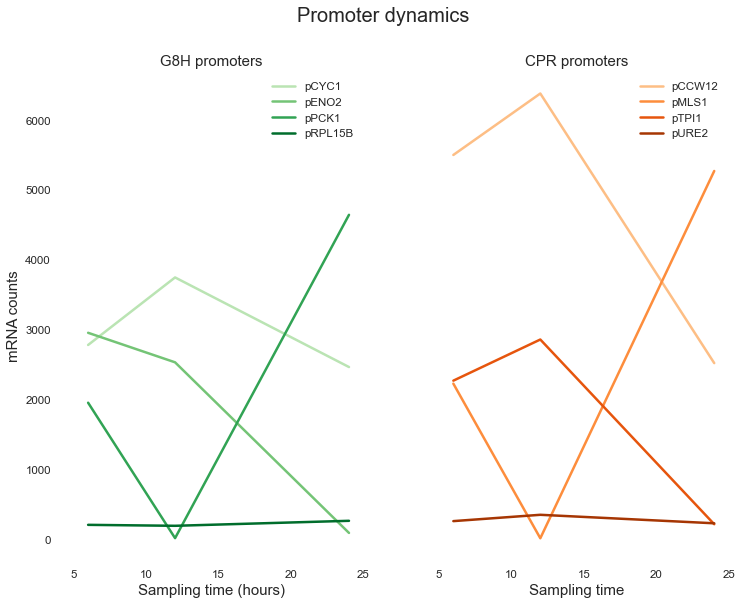

In [162]:
# Plotting an empty subplot
pg8H_color = ['#bae4b3','#74c476','#31a354','#006d2c']
pcpr_color = ['#fdbe85','#fd8d3c','#e6550d','#a63603']

import seaborn as sns
#set seaborn plotting aesthetics as default
sns.set()
sns.set_style("white")
sns.set_palette("pastel")
sns.set_context("paper", font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.despine(bottom = True, left = True)

# Plotting an empty subplot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,9), sharey=True)  # 1 row, 2 columns 

# Adding the DFs
ax1 = df_with_prom1.plot( ax=ax1, color = pg8H_color )
ax2 = df_with_prom2.plot( ax=ax2, color = pcpr_color)

# removes the borders around the plot
sns.despine(bottom = True, left = True)
ax1.legend(frameon=False) # around the legend
ax2.legend(frameon=False) # around the legend


# changing the range of the x axis
ax1.set_xlim(4,25)
ax2.set_xlim(4,25)

# Adding all the titles
ax1.set_title("G8H promoters",  fontsize=15)
ax2.set_title("CPR promoters",  fontsize=15)
fig.suptitle("Promoter dynamics", fontsize=20)
ax1.set_ylabel("mRNA counts",  fontsize=15)
ax1.set_xlabel("Sampling time (hours)", fontsize=15)
ax2.set_ylabel("mRNA counts",  fontsize=15)
ax2.set_xlabel("Sampling time", fontsize=15)


# saving the figure
#plt.savefig('Pictures/Dynamics_of_chosen_promoters.png', dpi = 120)

# 1. DATA wrangling

In this section the objective is to: 
    
    1. Import data from LC-MS analysis
    2. Merge that data with information on the plate setup and enzyme homologs (i.e. what each well has produced)
    3. Import sequencing data - filter it
    4. Genotype the different wells with which promoters was used
    5. Merge all the data so we end up with the following for each well analysed: 
        - Normalized production of strictosidine
        - Homolog combination 
        - Promoter combination 

With this information we can go to the next step which is the ML step. 

## 1.1 Merge Plate design yp49-52 metadata into single csv file


In [163]:
# importing xls file
xls = pd.ExcelFile('../data/raw/023_LC-MS/excel_files/plateDesign_yp48-51_MIA-HA-1-17_21-100.xls')

# reading the different sheets
df1 = pd.read_excel(xls, 'MIA-HA-1-17_yp48')  # plate 48
df1["plate"] = 'yp48' 

df2 = pd.read_excel(xls, 'MIA-HA-51-80_yp49') # plate 49
df2["plate"] = 'yp49' 

df3 = pd.read_excel(xls, 'MIA-HA-21-50_yp50') # plate 50
df3["plate"] = 'yp50' 

df4 = pd.read_excel(xls, 'MIA-HA-81-100_yp51')# plate 51
df4["plate"] = 'yp51' 

df5 = pd.read_excel(xls, 'yp52-HA-71-72')     # plate 52 has a few replicates that failed first time they were injected into the 
df5["plate"] = 'yp52' 


In [164]:
results_merged = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)

In [165]:
results_merged

,position,Sample name,Cellular Compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,genotype,plate,Cellular compartment
0,A01,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
1,A02,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
2,A03,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
3,A04,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
4,A05,NaN,NaN,YPD,Blank,30.0,144.0,NaN,Soeren Petersen,NaN,NaN,NaN,yp48,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,H08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp52,NaN
572,H09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp52,NaN
573,H10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp52,NaN
574,H11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yp52,NaN


In [166]:
results_merged.to_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp48-52_meta_analytics1.csv', header = True, index = False)

In [167]:
# read into a dataframe
PlateDesign = pd.read_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp48-52_meta_analytics1.csv') 

In [168]:
# we take the columns that we are interested in
PlateDesign= PlateDesign[['plate','position','Strain', 'Replicate #', 'genotype', 'Medium']]
# rename them
PlateDesign.columns = ['plate', 'well', 'strain','col_no', 'genotype', 'medium']
PlateDesign

,plate,well,strain,col_no,genotype,medium
0,yp48,A01,NaN,NaN,NaN,YPD
1,yp48,A02,NaN,NaN,NaN,YPD
2,yp48,A03,NaN,NaN,NaN,YPD
3,yp48,A04,NaN,NaN,NaN,YPD
4,yp48,A05,NaN,NaN,NaN,YPD
...,...,...,...,...,...,...
571,yp52,H08,NaN,NaN,NaN,NaN
572,yp52,H09,NaN,NaN,NaN,NaN
573,yp52,H10,NaN,NaN,NaN,NaN
574,yp52,H11,NaN,NaN,NaN,NaN


# 2. YP49-51 (library strains)

**Experiment:**

-   Strains: 3 colonies from each of 80 library plates. Each plate has specific combination of G8H and CPR but any of 16 possible promoter combinations
-   Media: YP + 2 % glucose + feed 0.2 mM geraniol & 1 mM tryptamine
-   Sampling: day 6

**Analytics notes:**

-   More than 500 uM tryptamine in all samples
-   No Loganic acid or Secologanin detected in any sample

**Wells not injected/acquired:**

-   Khem is not sure why.
    -   Volume is high enough.
    -   No bubbles as samples where filtered before handover (as well as spun down by Khem)
    -   Column clogging due to YPD?

Run 1

-   YP49
    -   A3, B1

Run 2

-   YP50
    -   :A9 A10, B3, B5, B9, C2, C4, C5, C9, D6
-   YP51
    -   :A3, A4, A9, A11, B7, B9, B10, C9, D3, E4

Run 3:

Rerun of samples not injected in run 2 as well as control(H7-11) for both plates rerun

-   YP50
    -   C5 and H7-11
-   YP51
    -   A11 and B9

## 1st Analytics

In [169]:
# Lets read in all the plates
plate49 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210519_tmet517_Soren.csv", sep = ',')
plate50 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210603_tmet525_yp50.csv", sep = ',')
plate51 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210603_tmet525_yp51.csv", sep = ',')
rerun = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210608_tmet525_reyp50-51.csv", sep = ',')
plate52 = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/Result_table_210621_tmet531_soren.csv", sep = ',')

# rerun has two columns that are controls that we dont need
rerun = rerun.iloc[2:]

# Stack the DataFrames on top of each other - Lets add the plate 49 from before
results2 = pd.concat([ plate49,plate50, plate51 , rerun, plate52], axis=0)

In [170]:
plate49.head(20)

,data_file,sample_notes,Amt_ug_L_Loganic acid,Amt_ug_L_Loganin,Amt_ug_L_Secologanin,Amt_ug_L_Strictosidine,Amt_ug_L_Tryptamine,Unnamed: 7,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine
0,210519_TMET517_018.xms,96WP1056_A01,NaN,NaN,NaN,143.890,146892.391,NaN,NaN,NaN,NaN,0.271199,916.816821
1,210519_TMET517_019.xms,96WP1056_A02,NaN,NaN,NaN,39.852,160741.781,NaN,NaN,NaN,NaN,0.075112,1003.256653
2,210519_TMET517_020.xms,96WP1056_A03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,210519_TMET517_021.xms,96WP1056_A04,NaN,NaN,NaN,29.985,135912.563,NaN,NaN,NaN,NaN,0.056515,848.287124
4,210519_TMET517_022.xms,96WP1056_A05,NaN,NaN,NaN,NaN,127009.570,NaN,NaN,NaN,NaN,NaN,792.719823
5,210519_TMET517_023.xms,96WP1056_A06,NaN,NaN,NaN,167.643,169995.156,NaN,NaN,NaN,NaN,0.315968,1061.010835
6,210519_TMET517_024.xms,96WP1056_A07,NaN,NaN,NaN,145.128,121216.961,NaN,NaN,NaN,NaN,0.273532,756.565728
7,210519_TMET517_025.xms,96WP1056_A08,NaN,NaN,NaN,33.090,101142.195,NaN,NaN,NaN,NaN,0.062367,631.270722
8,210519_TMET517_026.xms,96WP1056_A09,NaN,NaN,NaN,NaN,110753.844,NaN,NaN,NaN,NaN,NaN,691.261041
9,210519_TMET517_027.xms,96WP1056_A10,NaN,NaN,NaN,NaN,194969.500,NaN,NaN,NaN,NaN,NaN,1216.886157


 We filter for rows that has at least one of these compounds: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'

In [171]:
# filtering out all columns that that have Nan in all of the following columns: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'
df_filter = results2.dropna(subset=[ 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine' ],  how='all')

# replacing N.D and N.A. with NaN
df_filter = df_filter.replace('N.D.', np.NaN)
df_filter = df_filter.replace('N.A.', np.NaN)

# Excel contains values both in ug and uM. I'll use uM because values are in a better scale.
# remove cols starting with "Amt_ug_L_" because of redundancy and uM has better scale.
df_filter.drop(df_filter.iloc[:, 2:8], inplace = True, axis = 1)
df_filter
# saving the column names
list_of_coloumn_names = df_filter.columns.values.tolist()

# split the sample notes column
df_filter_plates = df_filter['sample_notes'].str.split('_', expand=True)
df_filter_plates.columns = ['sample', 'well']
list_of_coloumn_names_2 = df_filter_plates.columns.values.tolist()

# Add the to dataframes together
concatenated = pd.concat([df_filter, df_filter_plates], axis=1, ignore_index=True)
concatenated.columns = list_of_coloumn_names + list_of_coloumn_names_2

#df_filter_plates 
concatenated = concatenated.fillna(0)

In [172]:
concatenated

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.000000,0.0,0.271199,916.816821,0.000,0.000000,96WP1056,A01
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.000000,0.0,0.075112,1003.256653,0.000,0.000000,96WP1056,A02
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.000000,0.0,0.056515,848.287124,0.000,0.000000,96WP1056,A04
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.000000,0.0,0.000000,792.719823,0.000,0.000000,96WP1056,A05
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.000000,0.0,0.315968,1061.010835,0.000,0.000000,96WP1056,A06
...,...,...,...,...,...,...,...,...,...,...,...
52,210621_TMET531_393.xms,96WPYP50_H10,0.0,0.532433,0.0,21.218099,428.275914,68650.109,336.141160,96WPYP50,H10
53,210621_TMET531_394.xms,96WPYP50_H11,0.0,13.748222,0.0,69.678998,513.720634,55957.789,273.993972,96WPYP50,H11
54,210621_TMET531_523.xms,96WPYP49_H9,0.0,1.472949,0.0,21.149234,313.123873,68621.547,336.001307,96WPYP49,H9
55,210621_TMET531_524.xms,96WPYP49_H10,0.0,1.891014,0.0,28.581171,398.364162,68598.750,335.889683,96WPYP49,H10


In [173]:
## fixing the data - ADDING A zero between A1 --> A01
#for index, row in concatenated.iterrows():
#    if len(row['well']) == 2: 
#        letter, number = row['well'][0:1], row['well'][1:2]
#        print(letter, number)
#        row['well'] = str(letter) + '0' + str(number)
#        print(row['well'])


In [174]:
# copying sample to plate
results_copy = concatenated.copy()
results_copy['plate'] = results_copy['sample']
results_copy

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.000000,0.0,0.271199,916.816821,0.000,0.000000,96WP1056,A01,96WP1056
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.000000,0.0,0.075112,1003.256653,0.000,0.000000,96WP1056,A02,96WP1056
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.000000,0.0,0.056515,848.287124,0.000,0.000000,96WP1056,A04,96WP1056
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.000000,0.0,0.000000,792.719823,0.000,0.000000,96WP1056,A05,96WP1056
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.000000,0.0,0.315968,1061.010835,0.000,0.000000,96WP1056,A06,96WP1056
...,...,...,...,...,...,...,...,...,...,...,...,...
52,210621_TMET531_393.xms,96WPYP50_H10,0.0,0.532433,0.0,21.218099,428.275914,68650.109,336.141160,96WPYP50,H10,96WPYP50
53,210621_TMET531_394.xms,96WPYP50_H11,0.0,13.748222,0.0,69.678998,513.720634,55957.789,273.993972,96WPYP50,H11,96WPYP50
54,210621_TMET531_523.xms,96WPYP49_H9,0.0,1.472949,0.0,21.149234,313.123873,68621.547,336.001307,96WPYP49,H9,96WPYP49
55,210621_TMET531_524.xms,96WPYP49_H10,0.0,1.891014,0.0,28.581171,398.364162,68598.750,335.889683,96WPYP49,H10,96WPYP49


In [175]:
bool_series = results_copy.duplicated()
bool_series

0     False
1     False
3     False
4     False
5     False
      ...  
52    False
53    False
54    False
55    False
56    False
Length: 307, dtype: bool

In [176]:
#pd.set_option('display.max_rows', 1000)


getting the right plate name

In [177]:
results_copy.loc[results_copy['plate'] == '96WP1056', 'plate'] = 'yp49'
results_copy.loc[results_copy['plate'] == '96WPYP50', 'plate'] = 'yp50'
results_copy.loc[results_copy['plate'] == '96WPYP51', 'plate'] = 'yp51'
results_copy.loc[results_copy['plate'] == '96WPYP52', 'plate'] = 'yp52'

# for standardization
results_copy.loc[results_copy['plate'] == '96WPYP49', 'plate'] = 'yp49'

# adding plate 49 
results_copy_wiht_all_lcms = pd.concat([results_copy]) #, yp49
results_copy_wiht_all_lcms

well_list = results_copy_wiht_all_lcms['well'].to_list()
len(well_list)
results_copy_wiht_all_lcms

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.000000,0.0,0.271199,916.816821,0.000,0.000000,96WP1056,A01,yp49
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.000000,0.0,0.075112,1003.256653,0.000,0.000000,96WP1056,A02,yp49
3,210519_TMET517_021.xms,96WP1056_A04,0.0,0.000000,0.0,0.056515,848.287124,0.000,0.000000,96WP1056,A04,yp49
4,210519_TMET517_022.xms,96WP1056_A05,0.0,0.000000,0.0,0.000000,792.719823,0.000,0.000000,96WP1056,A05,yp49
5,210519_TMET517_023.xms,96WP1056_A06,0.0,0.000000,0.0,0.315968,1061.010835,0.000,0.000000,96WP1056,A06,yp49
...,...,...,...,...,...,...,...,...,...,...,...,...
52,210621_TMET531_393.xms,96WPYP50_H10,0.0,0.532433,0.0,21.218099,428.275914,68650.109,336.141160,96WPYP50,H10,yp50
53,210621_TMET531_394.xms,96WPYP50_H11,0.0,13.748222,0.0,69.678998,513.720634,55957.789,273.993972,96WPYP50,H11,yp50
54,210621_TMET531_523.xms,96WPYP49_H9,0.0,1.472949,0.0,21.149234,313.123873,68621.547,336.001307,96WPYP49,H9,yp49
55,210621_TMET531_524.xms,96WPYP49_H10,0.0,1.891014,0.0,28.581171,398.364162,68598.750,335.889683,96WPYP49,H10,yp49


Changing well names to systematical


In [178]:
well_list = results_copy_wiht_all_lcms['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

results_copy_wiht_all_lcms['well'] = new_well_list

In [179]:
PlateDesign

,plate,well,strain,col_no,genotype,medium
0,yp48,A01,NaN,NaN,NaN,YPD
1,yp48,A02,NaN,NaN,NaN,YPD
2,yp48,A03,NaN,NaN,NaN,YPD
3,yp48,A04,NaN,NaN,NaN,YPD
4,yp48,A05,NaN,NaN,NaN,YPD
...,...,...,...,...,...,...
571,yp52,H08,NaN,NaN,NaN,NaN
572,yp52,H09,NaN,NaN,NaN,NaN
573,yp52,H10,NaN,NaN,NaN,NaN
574,yp52,H11,NaN,NaN,NaN,NaN


In [180]:
PlateDesign['genotype'].count()

405

## 2.1 Merge lcms results with Platedesign

In [181]:
lcms_platedesign = pd.merge(results_copy_wiht_all_lcms, PlateDesign, on=['plate','well'])
lcms_platedesign = lcms_platedesign.loc[lcms_platedesign['plate'] != 'yp52']



lcms_platedesign

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate,strain,col_no,genotype,medium
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,0.0,0.0,96WP1056,A01,yp49,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,0.0,0.0,96WP1056,A02,yp49,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
2,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,0.0,0.0,96WP1056,A04,yp49,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
3,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,0.0,0.0,96WP1056,A05,yp49,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
4,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,0.0,0.0,96WP1056,A06,yp49,MIA-HA-52,3.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,210608_TMET525_168.xms,96WPYP51_B7,0.0,0.0,0.0,0.000000,1088.967513,0.0,0.0,96WPYP51,B07,yp51,MIA-HA-87,1.0,OeuG8H AniCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
258,210608_TMET525_171.xms,96WPYP51_B10,0.0,0.0,0.0,0.000000,924.953289,0.0,0.0,96WPYP51,B10,yp51,MIA-HA-88,1.0,OeuG8H CacCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
259,210608_TMET525_183.xms,96WPYP51_C9,0.0,0.0,0.0,1.198360,955.882830,0.0,0.0,96WPYP51,C09,yp51,MIA-HA-91,3.0,CcalG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
260,210608_TMET525_190.xms,96WPYP51_D3,0.0,0.0,0.0,0.820546,1203.266115,0.0,0.0,96WPYP51,D03,yp51,MIA-HA-93,3.0,CcalG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


#### Normalization

Lets normalize the strictosidine productions


In [182]:
# Filtering all control strains
control_strict_df = lcms_platedesign.loc[lcms_platedesign['strain'] == 'MIA-CH-A2']
control_strict_df = control_strict_df[:]

# selecting only ones that have more than 0
control_strict_df = control_strict_df.loc[control_strict_df['Amt_uM_Strictosidine'] >0]

df_mean = control_strict_df["Amt_uM_Strictosidine"].mean()
print(df_mean)
control_strict_df.head(20)

# the mean from the MIA-CH-A2 strain is ~ 32

30.503980937777776


,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate,strain,col_no,genotype,medium
88,210519_TMET517_128.xms,96WP1056_H07,0.0,5.985699,0.0,31.937737,923.984696,0.000,0.000000,96WP1056,H07,yp49,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
89,210519_TMET517_129.xms,96WP1056_H08,0.0,5.871533,0.0,34.732222,785.546143,0.000,0.000000,96WP1056,H08,yp49,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
90,210519_TMET517_130.xms,96WP1056_H09,0.0,2.170552,0.0,23.996807,604.312676,0.000,0.000000,96WP1056,H09,yp49,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
91,210621_TMET531_523.xms,96WPYP49_H9,0.0,1.472949,0.0,21.149234,313.123873,68621.547,336.001307,96WPYP49,H09,yp49,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
92,210519_TMET517_131.xms,96WP1056_H10,0.0,4.437494,0.0,26.888967,706.408276,0.000,0.000000,96WP1056,H10,yp49,MIA-CH-A2,4.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
93,210621_TMET531_524.xms,96WPYP49_H10,0.0,1.891014,0.0,28.581171,398.364162,68598.750,335.889683,96WPYP49,H10,yp49,MIA-CH-A2,4.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
177,210603_TMET525_128.xms,96WPYP50_H7,0.0,0.000000,0.0,41.072032,1067.329397,0.000,0.000000,96WPYP50,H07,yp50,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
178,210603_TMET525_129.xms,96WPYP50_H8,0.0,0.000000,0.0,29.259920,793.576414,0.000,0.000000,96WPYP50,H08,yp50,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
179,210603_TMET525_130.xms,96WPYP50_H9,0.0,3.063192,0.0,34.541111,1250.044470,0.000,0.000000,96WPYP50,H09,yp50,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
180,210621_TMET531_392.xms,96WPYP50_H9,0.0,1.518477,0.0,24.048593,467.631862,68587.758,335.835862,96WPYP50,H09,yp50,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


The mean strictosidine production per plate is generated here 

In [183]:
controls = control_strict_df.groupby(['plate']).mean()
controls = controls[['Amt_uM_Strictosidine']]
controls

,Amt_uM_Strictosidine
plate,
yp49,27.881023
yp50,30.727641
yp51,32.903279


In [184]:
control_yp49 = controls.loc['yp49', 'Amt_uM_Strictosidine']
control_yp50 = controls.loc['yp50', 'Amt_uM_Strictosidine']
control_yp51 = controls.loc['yp51', 'Amt_uM_Strictosidine']

In [185]:
norm_strict_df = lcms_platedesign.copy()
norm_strict_df['norm_strict_%'] = 0

In [186]:
for index, row in norm_strict_df.iterrows():
    #normalized = round(((row['Amt_uM_Strictosidine']/df_mean)*100),3)
    if row['plate'] == 'yp49': 
        normalized = ((row['Amt_uM_Strictosidine']/control_yp49)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
    
    if row['plate'] == 'yp50':
        normalized = ((row['Amt_uM_Strictosidine']/control_yp50)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized

    if row['plate'] == 'yp51':
        normalized = ((row['Amt_uM_Strictosidine']/control_yp51)*100)
        norm_strict_df.at[index, 'norm_strict_%'] = normalized
    
norm_strict_df

,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate,strain,col_no,genotype,medium,norm_strict_%
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,0.0,0.0,96WP1056,A01,yp49,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.972701
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,0.0,0.0,96WP1056,A02,yp49,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.269401
2,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,0.0,0.0,96WP1056,A04,yp49,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.202699
3,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,0.0,0.0,96WP1056,A05,yp49,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000
4,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,0.0,0.0,96WP1056,A06,yp49,MIA-HA-52,3.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,1.133272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,210608_TMET525_168.xms,96WPYP51_B7,0.0,0.0,0.0,0.000000,1088.967513,0.0,0.0,96WPYP51,B07,yp51,MIA-HA-87,1.0,OeuG8H AniCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000
258,210608_TMET525_171.xms,96WPYP51_B10,0.0,0.0,0.0,0.000000,924.953289,0.0,0.0,96WPYP51,B10,yp51,MIA-HA-88,1.0,OeuG8H CacCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000
259,210608_TMET525_183.xms,96WPYP51_C9,0.0,0.0,0.0,1.198360,955.882830,0.0,0.0,96WPYP51,C09,yp51,MIA-HA-91,3.0,CcalG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,3.642069
260,210608_TMET525_190.xms,96WPYP51_D3,0.0,0.0,0.0,0.820546,1203.266115,0.0,0.0,96WPYP51,D03,yp51,MIA-HA-93,3.0,CcalG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,2.493812


In [187]:
# we have to make all the values into floats in order to sort them 
#merged_inner1['Amt_uM_Strictosidine'] = pd.to_numeric(merged_inner1['Amt_uM_Strictosidine'], downcast='float')
sorted_df = norm_strict_df.sort_values(by='norm_strict_%', ascending=False)
sorted_df = sorted_df.reset_index()


# Lets remove Mia-CM3 - the control
sorted_df = sorted_df[sorted_df['strain'] != 'MIA-CM-3' ]
sorted_df_lcms = sorted_df [sorted_df['strain'] != 'MIA-CH-A2' ]

# removing the rest of plate 52 that were not our results
sorted_df_lcms1 = sorted_df_lcms.loc[sorted_df_lcms['plate'] != 'yp52']

sorted_df_lcms1["Line_name"] = sorted_df_lcms1["plate"] +'_'+ sorted_df_lcms1["well"]

sorted_df_lcms1

,index,data_file,sample_notes,Amt_uM_Loganic acid,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,well,plate,strain,col_no,genotype,medium,norm_strict_%,Line_name
1,126,210603_TMET525_059.xms,96WPYP50_D3,0.0,26.235847,0.0,85.210149,2021.748028,0.0,0.0,96WPYP50,D03,yp50,MIA-HA-33,3.0,SmusG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,277.307816,yp50_D03
6,161,210603_TMET525_111.xms,96WPYP50_G3,0.0,8.632279,0.0,54.362482,1476.111166,0.0,0.0,96WPYP50,G03,yp50,MIA-HA-45,3.0,RsepG8H RseCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,176.917201,yp50_G03
7,139,210603_TMET525_087.xms,96WPYP50_E5,0.0,8.009680,0.0,50.194227,1731.472157,0.0,0.0,96WPYP50,E05,yp50,MIA-HA-38,2.0,SmusG8H CacCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,163.352037,yp50_E05
8,245,210608_TMET525_026.xms,96WPYP50_A9,0.0,5.631651,0.0,46.710102,1991.122556,0.0,0.0,96WPYP50,A09,yp50,MIA-HA-23,3.0,VminG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,152.013305,yp50_A09
10,187,210603_TMET525_150.xms,96WPYP51_A2,0.0,5.086582,0.0,46.443319,1798.561547,0.0,0.0,96WPYP51,A02,yp51,MIA-HA-81,2.0,OeuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,141.151036,yp51_A02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,109,210603_TMET525_034.xms,96WPYP50_B4,0.0,0.000000,0.0,0.000000,1108.870809,0.0,0.0,96WPYP50,B04,yp50,MIA-HA-26,1.0,VminG8H AhuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,yp50_B04
258,44,210519_TMET517_067.xms,96WP1056_D11,0.0,0.000000,0.0,0.000000,587.090114,0.0,0.0,96WP1056,D11,yp49,MIA-HA-66,2.0,OpumG8H AhuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,yp49_D11
259,45,210519_TMET517_068.xms,96WP1056_D12,0.0,0.000000,0.0,0.000000,619.353271,0.0,0.0,96WP1056,D12,yp49,MIA-HA-66,3.0,OpumG8H AhuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,yp49_D12
260,48,210519_TMET517_085.xms,96WP1056_E03,0.0,0.000000,0.0,0.000000,715.084384,0.0,0.0,96WP1056,E03,yp49,MIA-HA-67,3.0,OpumG8H AniCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol,0.000000,yp49_E03



## 1.6 2nd Analytics
**Experiment**


Due to large deviations in the data found, the LC-MS was run on all sample again

In [188]:
# Lets read in plate 49-51

plate49duplicate = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/rerun/Result_table_211108_tmet601_96wp1056.csv", sep = ',')
plate50duplicate = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/rerun/Result_table_211108_tmet601_96wp1332.csv", sep = ',')
plate51duplicate = pd.read_csv("ConStrain_on_google_colab/Data/raw/023_LC-MS/rerun/Result_table_211111_tmet601_96wp1333.csv", sep = ',')


# Stack the DataFrames on top of each other - Lets add the plate 49 from before
unprocessed_lcms_results2 = pd.concat([ plate49duplicate, plate50duplicate, plate51duplicate ], axis=0)
unprocessed_lcms_results2

,data_file,sample_notes,Amt_ug_L_Loganin,Amt_ug_L_Secologanin,Amt_ug_L_Strictosidine,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine
0,211108_TMET601_003.xms,96WP1056_A1,NaN,NaN,191.080,188793.953,NaN,NaN,0.360141,1178.341986
1,211108_TMET601_004.xms,96WP1056_A2,NaN,NaN,43.365,218863.750,NaN,NaN,0.081733,1366.020160
2,211108_TMET601_005.xms,96WP1056_A3,NaN,NaN,36.259,192608.344,NaN,NaN,0.068340,1202.149195
3,211108_TMET601_006.xms,96WP1056_A4,NaN,NaN,30.142,164785.266,NaN,NaN,0.056811,1028.493734
4,211108_TMET601_007.xms,96WP1056_A5,NaN,NaN,6.361,189360.844,NaN,NaN,0.011989,1181.880190
...,...,...,...,...,...,...,...,...,...,...
61,211111_TMET601_350.xms,96WP1333_H8,2121.536,NaN,20232.879,223805.531,5.434541,NaN,38.134231,1396.863881
62,211111_TMET601_351.xms,96WP1333_H9,2335.761,NaN,20395.418,208438.109,5.983301,NaN,38.440579,1300.949376
63,211111_TMET601_352.xms,96WP1333_H10,1715.397,NaN,17532.178,199978.688,4.394172,NaN,33.044043,1248.150593
64,211111_TMET601_353.xms,96WP1333_H11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
# filtering out all columns that that have Nan in all of the following columns: 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine'
df_filter = unprocessed_lcms_results2.dropna(subset=[ 'Amt_uM_Loganin', 'Amt_uM_Secologanin','Amt_uM_Strictosidine', 'Amt_uM_Tryptamine' ],  how='all')

# replacing N.D and N.A. with NaN
df_filter = df_filter.replace('N.D.', np.NaN)
df_filter = df_filter.replace('N.A.', np.NaN)

# Excel contains values both in ug and uM. I'll use uM because values are in a better scale.
# remove cols starting with "Amt_ug_L_" because of redundancy and uM has better scale.
df_filter.drop(df_filter.iloc[:, 2:5], inplace = True, axis = 1)
df_filter

#df_filter
## saving the column names
list_of_coloumn_names = df_filter.columns.values.tolist()
#
## split the sample notes column
df_filter_plates = df_filter['sample_notes'].str.split('_', expand=True)
df_filter_plates = df_filter_plates[[0,1]]
df_filter_plates.columns = ['plate', 'well']
list_of_coloumn_names_2 = df_filter_plates.columns.values.tolist()
#
## Add the to dataframes together
concatenated = pd.concat([df_filter, df_filter_plates], axis=1, ignore_index=True)
concatenated.columns = list_of_coloumn_names + list_of_coloumn_names_2

##add 0 to all nan positions 
concatenated = concatenated.fillna(0)


### Changing the names of the plates to yp53/54
concatenated.loc[concatenated['plate'] == '96WP1056', 'plate'] = 'yp49'
concatenated.loc[concatenated['plate'] == '96WP1332', 'plate'] = 'yp50'
concatenated.loc[concatenated['plate'] == '96WP1333', 'plate'] = 'yp51'

# Change name
lcms_results2 = concatenated
lcms_results2

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well
0,211108_TMET601_003.xms,96WP1056_A1,188793.953,0.000000,0.0,0.360141,1178.341986,yp49,A1
1,211108_TMET601_004.xms,96WP1056_A2,218863.750,0.000000,0.0,0.081733,1366.020160,yp49,A2
2,211108_TMET601_005.xms,96WP1056_A3,192608.344,0.000000,0.0,0.068340,1202.149195,yp49,A3
3,211108_TMET601_006.xms,96WP1056_A4,164785.266,0.000000,0.0,0.056811,1028.493734,yp49,A4
4,211108_TMET601_007.xms,96WP1056_A5,189360.844,0.000000,0.0,0.011989,1181.880190,yp49,A5
...,...,...,...,...,...,...,...,...,...
60,211111_TMET601_349.xms,96WP1333_H7,217829.438,4.878129,0.0,37.737237,1359.564586,yp51,H7
61,211111_TMET601_350.xms,96WP1333_H8,223805.531,5.434541,0.0,38.134231,1396.863881,yp51,H8
62,211111_TMET601_351.xms,96WP1333_H9,208438.109,5.983301,0.0,38.440579,1300.949376,yp51,H9
63,211111_TMET601_352.xms,96WP1333_H10,199978.688,4.394172,0.0,33.044043,1248.150593,yp51,H10


In [190]:
## changing the well names to incorporate a 0 between the first wells

In [191]:
well_list = lcms_results2['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

lcms_results2['well'] = new_well_list
lcms_results2

,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well
0,211108_TMET601_003.xms,96WP1056_A1,188793.953,0.000000,0.0,0.360141,1178.341986,yp49,A01
1,211108_TMET601_004.xms,96WP1056_A2,218863.750,0.000000,0.0,0.081733,1366.020160,yp49,A02
2,211108_TMET601_005.xms,96WP1056_A3,192608.344,0.000000,0.0,0.068340,1202.149195,yp49,A03
3,211108_TMET601_006.xms,96WP1056_A4,164785.266,0.000000,0.0,0.056811,1028.493734,yp49,A04
4,211108_TMET601_007.xms,96WP1056_A5,189360.844,0.000000,0.0,0.011989,1181.880190,yp49,A05
...,...,...,...,...,...,...,...,...,...
60,211111_TMET601_349.xms,96WP1333_H7,217829.438,4.878129,0.0,37.737237,1359.564586,yp51,H07
61,211111_TMET601_350.xms,96WP1333_H8,223805.531,5.434541,0.0,38.134231,1396.863881,yp51,H08
62,211111_TMET601_351.xms,96WP1333_H9,208438.109,5.983301,0.0,38.440579,1300.949376,yp51,H09
63,211111_TMET601_352.xms,96WP1333_H10,199978.688,4.394172,0.0,33.044043,1248.150593,yp51,H10


In [192]:
# importing xls file
xls = pd.ExcelFile('ConStrain_on_google_colab/Data/raw/023_LC-MS/excel_files/analytics_all_platedesign.xlsx')


#xls = pd.ExcelFile('/Users/lucaslevassor/Desktop/g8h_cpr_library 2/data/raw/023_LC-MS/plateDesign_yp53-54_MIA-HA-111-145.xlsx')

# reading the different sheets
df49 = pd.read_excel(xls, '49')  # plate 53
df49["plate"] = 'yp49' 

# reading the different sheets
df50 = pd.read_excel(xls, '50')  # plate 53
df50["plate"] = 'yp50' 

# reading the different sheets
df51 = pd.read_excel(xls, '51')  # plate 53
df51["plate"] = 'yp51' 

In [193]:
results_merged2 = pd.concat([df49, df50, df51], ignore_index=True)
results_merged2

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,genotype,plate
0,A01,MIA-HA-51_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,1.0,MIA-HA-51,CacuG8H CroCPR,yp49
1,A02,MIA-HA-51_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-HA-51,CacuG8H CroCPR,yp49
2,A03,MIA-HA-51_3,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,3.0,MIA-HA-51,CacuG8H CroCPR,yp49
3,A04,MIA-HA-52_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,1.0,MIA-HA-52,CacuG8H AanCPR,yp49
4,A05,MIA-HA-52_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-HA-52,CacuG8H AanCPR,yp49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,H08,MIA-CH-A2_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-CH-A2,CroG8H CroCPR,yp51
284,H09,MIA-CH-A2_3,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,3.0,MIA-CH-A2,CroG8H CroCPR,yp51
285,H10,MIA-CH-A2_4,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,4.0,MIA-CH-A2,CroG8H CroCPR,yp51
286,H11,MIA-CM-3_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,1.0,MIA-CM-3,CroG8H CroCPR,yp51


In [194]:
results_merged2['well'] = results_merged2['position']

In [195]:
results_merged2.tail(50)

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,genotype,plate,well
238,D11,MIA-HA-96_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-HA-96,CcalG8H AhuCPR,yp51,D11
239,D12,MIA-HA-96_3,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,3.0,MIA-HA-96,CcalG8H AhuCPR,yp51,D12
240,E01,MIA-HA-97_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,1.0,MIA-HA-97,CcalG8H AniCPR,yp51,E01
241,E02,MIA-HA-97_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-HA-97,CcalG8H AniCPR,yp51,E02
242,E03,MIA-HA-97_3,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,3.0,MIA-HA-97,CcalG8H AniCPR,yp51,E03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,H08,MIA-CH-A2_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-CH-A2,CroG8H CroCPR,yp51,H08
284,H09,MIA-CH-A2_3,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,3.0,MIA-CH-A2,CroG8H CroCPR,yp51,H09
285,H10,MIA-CH-A2_4,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,4.0,MIA-CH-A2,CroG8H CroCPR,yp51,H10
286,H11,MIA-CM-3_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,1.0,MIA-CM-3,CroG8H CroCPR,yp51,H11


In [196]:
results_merged2.to_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp49-51_duplicated.csv', header = True, index = False)

In [197]:
# read into a dataframe
PlateDesign1 = pd.read_csv('ConStrain_on_google_colab/Data/processed/023_LC-MS/yp49-51_duplicated.csv') 
PlateDesign1

,position,Sample name,Cellular compartment,Medium,Sample Type,Temperature (C),Timepoint (h),Cultivation Container ID/Position,Operator Name,Replicate #,Strain,genotype,plate,well
0,A01,MIA-HA-51_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,1.0,MIA-HA-51,CacuG8H CroCPR,yp49,A01
1,A02,MIA-HA-51_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-HA-51,CacuG8H CroCPR,yp49,A02
2,A03,MIA-HA-51_3,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,3.0,MIA-HA-51,CacuG8H CroCPR,yp49,A03
3,A04,MIA-HA-52_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,1.0,MIA-HA-52,CacuG8H AanCPR,yp49,A04
4,A05,MIA-HA-52_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-HA-52,CacuG8H AanCPR,yp49,A05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,H08,MIA-CH-A2_2,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,2.0,MIA-CH-A2,CroG8H CroCPR,yp51,H08
284,H09,MIA-CH-A2_3,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,3.0,MIA-CH-A2,CroG8H CroCPR,yp51,H09
285,H10,MIA-CH-A2_4,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,4.0,MIA-CH-A2,CroG8H CroCPR,yp51,H10
286,H11,MIA-CM-3_1,Extracellular Region,YPD + 1 mM tryptamine + 0.2 mM geraniol,Specimen,30,144,NaN,Soeren Petersen,1.0,MIA-CM-3,CroG8H CroCPR,yp51,H11


In [198]:
#pd.set_option('display.max_rows', 100)

In [199]:
# we take the columns that we are interested in
PlateDesign1= PlateDesign1[['plate','position','Strain', 'Replicate #', 'genotype', 'Medium' ]]
# rename them
PlateDesign1.columns = ['plate', 'well', 'strain','col_no', 'genotype', 'medium']
PlateDesign1

,plate,well,strain,col_no,genotype,medium
0,yp49,A01,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
1,yp49,A02,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
2,yp49,A03,MIA-HA-51,3.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
3,yp49,A04,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
4,yp49,A05,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
...,...,...,...,...,...,...
283,yp51,H08,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
284,yp51,H09,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
285,yp51,H10,MIA-CH-A2,4.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
286,yp51,H11,MIA-CM-3,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


In [200]:
# Merge our lcms file with the genotype/strain 
lcms_platedesign2 = pd.merge(lcms_results2, PlateDesign1, left_on=['plate','well'], right_on = ['plate','well'])
lcms_platedesign2.to_clipboard()

#### Normalizing

In [201]:
control_strict_df2 = lcms_platedesign2.loc[lcms_platedesign2['strain'] == 'MIA-CH-A2']
df_mean = control_strict_df2["Amt_uM_Strictosidine"].mean()
print(df_mean)
control_strict_df2

29.2332472623782


,data_file,sample_notes,Amt_ug_L_Tryptamine,Amt_uM_Loganin,Amt_uM_Secologanin,Amt_uM_Strictosidine,Amt_uM_Tryptamine,plate,well,strain,col_no,genotype,medium
90,211108_TMET601_113.xms,96WP1056_H7,193945.172,3.480155,0.0,24.227146,1210.492897,yp49,H07,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
91,211108_TMET601_114.xms,96WP1056_H8,183610.328,1.763446,0.0,21.416788,1145.988815,yp49,H08,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
92,211108_TMET601_115.xms,96WP1056_H9,124853.078,1.832853,0.0,15.203788,779.260255,yp49,H09,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
93,211108_TMET601_116.xms,96WP1056_H10,131074.250,2.744654,0.0,19.354245,818.089190,yp49,H10,MIA-CH-A2,4.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
186,211108_TMET601_244.xms,96WP1332_H7,145643.797,2.966000,0.0,30.242607,909.023823,yp50,H07,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
187,211108_TMET601_245.xms,96WP1332_H8,137144.969,2.319063,0.0,27.797461,855.979085,yp50,H08,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
188,211108_TMET601_246.xms,96WP1332_H9,219627.047,3.831682,0.0,37.488267,1370.784215,yp50,H09,MIA-CH-A2,3.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
189,211108_TMET601_247.xms,96WP1332_H10,153911.531,3.130281,0.0,27.712573,960.626208,yp50,H10,MIA-CH-A2,4.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
226,211111_TMET601_349.xms,96WP1333_H7,217829.438,4.878129,0.0,37.737237,1359.564586,yp51,H07,MIA-CH-A2,1.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
227,211111_TMET601_350.xms,96WP1333_H8,223805.531,5.434541,0.0,38.134231,1396.863881,yp51,H08,MIA-CH-A2,2.0,CroG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


In [202]:
# GETTING RID OF ZEROS
control_strict_df2 = control_strict_df2.loc[control_strict_df2['Amt_uM_Strictosidine'] > 0]

controls = control_strict_df2.groupby(['plate']).mean()
controls = controls[['Amt_uM_Strictosidine']]
controls

,Amt_uM_Strictosidine
plate,
yp49,20.050492
yp50,30.810227
yp51,36.839023


In [203]:
lcms_platedesign["Line_name"] = lcms_platedesign["plate"] +'_'+ lcms_platedesign["well"]
lcms_platedesign2["Line_name"] = lcms_platedesign2["plate"] +'_'+ lcms_platedesign2["well"]

In [204]:
print(len(lcms_platedesign))
print(len(lcms_platedesign2))
print(len(sorted_df_lcms)+len(lcms_platedesign))

262
231
500


In [205]:
df_merged_left = lcms_platedesign.merge(lcms_platedesign2, how='left', on='Line_name')
df_merged_left

,data_file_x,sample_notes_x,Amt_uM_Loganic acid,Amt_uM_Loganin_x,Amt_uM_Secologanin_x,Amt_uM_Strictosidine_x,Amt_uM_Tryptamine_x,Amt_ug_L_Tryptophan,Amt_uM_Tryptophan,sample,...,Amt_uM_Loganin_y,Amt_uM_Secologanin_y,Amt_uM_Strictosidine_y,Amt_uM_Tryptamine_y,plate_y,well_y,strain_y,col_no_y,genotype_y,medium_y
0,210519_TMET517_018.xms,96WP1056_A01,0.0,0.0,0.0,0.271199,916.816821,0.0,0.0,96WP1056,...,0.0,0.0,0.360141,1178.341986,yp49,A01,MIA-HA-51,1.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
1,210519_TMET517_019.xms,96WP1056_A02,0.0,0.0,0.0,0.075112,1003.256653,0.0,0.0,96WP1056,...,0.0,0.0,0.081733,1366.020160,yp49,A02,MIA-HA-51,2.0,CacuG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
2,210519_TMET517_021.xms,96WP1056_A04,0.0,0.0,0.0,0.056515,848.287124,0.0,0.0,96WP1056,...,0.0,0.0,0.056811,1028.493734,yp49,A04,MIA-HA-52,1.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
3,210519_TMET517_022.xms,96WP1056_A05,0.0,0.0,0.0,0.000000,792.719823,0.0,0.0,96WP1056,...,0.0,0.0,0.011989,1181.880190,yp49,A05,MIA-HA-52,2.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
4,210519_TMET517_023.xms,96WP1056_A06,0.0,0.0,0.0,0.315968,1061.010835,0.0,0.0,96WP1056,...,0.0,0.0,0.343082,1169.523256,yp49,A06,MIA-HA-52,3.0,CacuG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,210608_TMET525_168.xms,96WPYP51_B7,0.0,0.0,0.0,0.000000,1088.967513,0.0,0.0,96WPYP51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258,210608_TMET525_171.xms,96WPYP51_B10,0.0,0.0,0.0,0.000000,924.953289,0.0,0.0,96WPYP51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,210608_TMET525_183.xms,96WPYP51_C9,0.0,0.0,0.0,1.198360,955.882830,0.0,0.0,96WPYP51,...,0.0,0.0,2.434844,1234.504119,yp51,C09,MIA-HA-91,3.0,CcalG8H CroCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
260,210608_TMET525_190.xms,96WPYP51_D3,0.0,0.0,0.0,0.820546,1203.266115,0.0,0.0,96WPYP51,...,0.0,0.0,0.616492,1208.206491,yp51,D03,MIA-HA-93,3.0,CcalG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


In [206]:
df_merged_left = df_merged_left[['Line_name','plate_x','well_x',   'Amt_uM_Strictosidine_x','plate_y','well_y', 'Amt_uM_Strictosidine_y']]
df_merged_left.head(50)
print(len(df_merged_left))

262


In [207]:
control_yp49_duplicated = controls.loc['yp49', 'Amt_uM_Strictosidine']
control_yp50_duplicated = controls.loc['yp50', 'Amt_uM_Strictosidine']
control_yp51_duplicated = controls.loc['yp51', 'Amt_uM_Strictosidine']

control_yp50_duplicated

30.810227208473876

In [208]:
# make a copy and a new row
norm_strict_df1 = df_merged_left.copy()
norm_strict_df1['norm_strict_x'] = 0
norm_strict_df1['norm_strict_y'] = 0
norm_strict_df1['norm_strict_mean'] = 0

for index, row in norm_strict_df1.iterrows():
    
    # normalization for 1st analytics 
    if row['plate_x'] == 'yp49': 
        normalized = ((row['Amt_uM_Strictosidine_x']/control_yp49)*100)
        norm_strict_df1.at[index, 'norm_strict_x'] = normalized
    
    if row['plate_x'] == 'yp50':
        normalized = ((row['Amt_uM_Strictosidine_x']/control_yp50)*100)
        norm_strict_df1.at[index, 'norm_strict_x'] = normalized
    
    if row['plate_x'] == 'yp51':
        normalized = ((row['Amt_uM_Strictosidine_x']/control_yp51)*100)
        norm_strict_df1.at[index, 'norm_strict_x'] = normalized
        
        
    # normalization for 1st analytics 
    
    if row['plate_y'] == 'yp49':
        normalized = ((row['Amt_uM_Strictosidine_y']/control_yp49_duplicated)*100)
        norm_strict_df1.at[index, 'norm_strict_y'] = normalized
        
    if row['plate_y'] == 'yp50':
        normalized = ((row['Amt_uM_Strictosidine_y']/control_yp50_duplicated)*100)
        norm_strict_df1.at[index, 'norm_strict_y'] = normalized
    
    if row['plate_y'] == 'yp51':
        normalized = ((row['Amt_uM_Strictosidine_y']/control_yp51_duplicated)*100)
        norm_strict_df1.at[index, 'norm_strict_y'] = normalized

        
for index, row in norm_strict_df1.iterrows():
    norm_strict_df1.at[index, 'norm_strict_mean'] = ((row['norm_strict_x']+row['norm_strict_y'] )/2)
    
    
pd.set_option('display.max_rows', 50)  # or 1000
norm_strict_df1

,Line_name,plate_x,well_x,Amt_uM_Strictosidine_x,plate_y,well_y,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean
0,yp49_A01,yp49,A01,0.271199,yp49,A01,0.360141,0.972701,1.796170,1.384435
1,yp49_A02,yp49,A02,0.075112,yp49,A02,0.081733,0.269401,0.407635,0.338518
2,yp49_A04,yp49,A04,0.056515,yp49,A04,0.056811,0.202699,0.283338,0.243019
3,yp49_A05,yp49,A05,0.000000,yp49,A05,0.011989,0.000000,0.059794,0.029897
4,yp49_A06,yp49,A06,0.315968,yp49,A06,0.343082,1.133272,1.711090,1.422181
...,...,...,...,...,...,...,...,...,...,...
257,yp51_B07,yp51,B07,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
258,yp51_B10,yp51,B10,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
259,yp51_C09,yp51,C09,1.198360,yp51,C09,2.434844,3.642069,6.609414,5.125742
260,yp51_D03,yp51,D03,0.820546,yp51,D03,0.616492,2.493812,1.673475,2.083643


In [209]:
norm_strict_df1_sorted = norm_strict_df1.sort_values(by='norm_strict_mean', ascending=False)

norm_strict_df1_sorted

,Line_name,plate_x,well_x,Amt_uM_Strictosidine_x,plate_y,well_y,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean
242,yp51_H11,yp51,H11,140.371248,NaN,NaN,NaN,426.617807,0.000000,213.308903
126,yp50_D03,yp50,D03,85.210149,yp50,D03,38.234719,277.307816,124.097492,200.702654
61,yp49_F04,yp49,F04,38.738052,yp49,F04,34.861185,138.940568,173.866982,156.403775
95,yp49_H11,yp49,H11,52.062489,yp49,H11,20.582901,186.730916,102.655344,144.693130
161,yp50_G03,yp50,G03,54.362482,yp50,G03,29.186584,176.917201,94.730182,135.823691
...,...,...,...,...,...,...,...,...,...,...
17,yp49_B08,yp49,B08,0.000000,yp49,B08,0.000000,0.000000,0.000000,0.000000
16,yp49_B07,yp49,B07,0.000000,yp49,B07,0.000000,0.000000,0.000000,0.000000
15,yp49_B06,yp49,B06,0.000000,yp49,B06,0.000000,0.000000,0.000000,0.000000
14,yp49_B05,yp49,B05,0.000000,yp49,B05,0.000000,0.000000,0.000000,0.000000


#### Merging data with plate_design

In [210]:
### Merging back to get genotypes - we can use the platedesign becayce we 
sorted_df_lcms = pd.merge(norm_strict_df1, PlateDesign1, left_on=['plate_x','well_x'], right_on = ['plate','well'])

# getting rid of MIA-CM-3 and CH-A2
sorted_df_lcms = sorted_df_lcms[sorted_df_lcms['strain'] != 'MIA-CM-3' ]
sorted_df_lcms = sorted_df_lcms[sorted_df_lcms['strain'] != 'MIA-CH-A2' ]

sorted_df_lcms2 =  sorted_df_lcms.sort_values(by='norm_strict_mean', ascending=False).reset_index()
print(len(sorted_df_lcms2))
sorted_df_lcms2.head(10)

238


,index,Line_name,plate_x,well_x,Amt_uM_Strictosidine_x,plate_y,well_y,Amt_uM_Strictosidine_y,norm_strict_x,norm_strict_y,norm_strict_mean,plate,well,strain,col_no,genotype,medium
0,126,yp50_D03,yp50,D03,85.210149,yp50,D03,38.234719,277.307816,124.097492,200.702654,yp50,D03,MIA-HA-33,3.0,SmusG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
1,61,yp49_F04,yp49,F04,38.738052,yp49,F04,34.861185,138.940568,173.866982,156.403775,yp49,F04,MIA-HA-72,1.0,CroG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
2,161,yp50_G03,yp50,G03,54.362482,yp50,G03,29.186584,176.917201,94.730182,135.823691,yp50,G03,MIA-HA-45,3.0,RsepG8H RseCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
3,129,yp50_D07,yp50,D07,43.089372,yp50,D07,34.980725,140.230004,113.536081,126.883042,yp50,D07,MIA-HA-35,1.0,SmusG8H RseCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
4,62,yp49_F05,yp49,F05,23.042011,yp49,F05,33.078461,82.644068,164.975807,123.809937,yp49,F05,MIA-HA-72,2.0,CroG8H AanCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
5,156,yp50_F10,yp50,F10,34.938195,yp50,F10,38.642743,113.702822,125.421804,119.562313,yp50,F10,MIA-HA-44,1.0,RsepG8H CloCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
6,139,yp50_E05,yp50,E05,50.194227,yp50,E05,22.853009,163.352037,74.173452,118.762744,yp50,E05,MIA-HA-38,2.0,SmusG8H CacCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
7,245,yp50_A09,yp50,A09,46.710102,yp50,A09,15.975195,152.013305,51.850298,101.931802,yp50,A09,MIA-HA-23,3.0,VminG8H AraCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
8,128,yp50_D05,yp50,D05,28.857107,yp50,D05,21.734544,93.912536,70.543277,82.227906,yp50,D05,MIA-HA-34,2.0,SmusG8H CloCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol
9,142,yp50_E08,yp50,E08,25.190653,yp50,E08,23.679475,81.980435,76.855892,79.418163,yp50,E08,MIA-HA-39,2.0,SmusG8H OeuCPR,YPD + 1 mM tryptamine + 0.2 mM geraniol


### Merging all datapoints^ into one dataframe - 1 sample per row


In [211]:
first_analytics = {'Line_name': list(sorted_df_lcms2['Line_name']), 
                  'Normalized_strictosidine': list(sorted_df_lcms2['norm_strict_x']),
                  'Strain': list(sorted_df_lcms2['strain']),
                  'Genotype': list(sorted_df_lcms2['genotype'])}


second_analytics = {'Line_name': list(sorted_df_lcms2['Line_name']), 
                  'Normalized_strictosidine': list(sorted_df_lcms2['norm_strict_y']),
                  'Strain': list(sorted_df_lcms2['strain']),
                  'Genotype': list(sorted_df_lcms2['genotype'])}

df_first_analytics = pd.DataFrame(first_analytics)
df_second_analytics = pd.DataFrame(second_analytics)
df_first_and_second_round = pd.concat([df_first_analytics,df_second_analytics])
df_first_and_second_round

,Line_name,Normalized_strictosidine,Strain,Genotype
0,yp50_D03,277.307816,MIA-HA-33,SmusG8H AraCPR
1,yp49_F04,138.940568,MIA-HA-72,CroG8H AanCPR
2,yp50_G03,176.917201,MIA-HA-45,RsepG8H RseCPR
3,yp50_D07,140.230004,MIA-HA-35,SmusG8H RseCPR
4,yp49_F05,82.644068,MIA-HA-72,CroG8H AanCPR
...,...,...,...,...
233,yp50_B07,0.000000,MIA-HA-27,VminG8H AniCPR
234,yp49_B05,0.000000,MIA-HA-56,CacuG8H AhuCPR
235,yp50_B06,0.000000,MIA-HA-26,VminG8H AhuCPR
236,yp50_B04,0.000000,MIA-HA-26,VminG8H AhuCPR


In [212]:
df_first_and_second_round = df_first_and_second_round[df_first_and_second_round['Line_name'] != 'yp52' ]


In [213]:
# Statistics on the strains

std = df_first_and_second_round.groupby('Strain')['Normalized_strictosidine'].std()
len(std)
std

Strain
MIA-HA-100     1.478895
MIA-HA-21      3.968081
MIA-HA-22      1.017747
MIA-HA-23     55.007468
MIA-HA-24      1.436004
                ...    
MIA-HA-95      0.577431
MIA-HA-96      0.487246
MIA-HA-97      0.267719
MIA-HA-98      0.466478
MIA-HA-99      2.374284
Name: Normalized_strictosidine, Length: 80, dtype: float64

### trying to plot fist and second ana

In [306]:
new_def_strain_first_ana = df_first_analytics.groupby(['Strain']).Normalized_strictosidine.agg({'mean','std'})
new_def_strain_SECOND_ana = df_second_analytics.groupby(['Strain']).Normalized_strictosidine.agg({'mean','std'})

# sort_by mean
new_def_strain_first_ana = new_def_strain_first_ana.sort_values(by= 'mean', ascending = False)
new_def_strain_SECOND_ana = new_def_strain_SECOND_ana.sort_values(by= 'mean', ascending = False)


# calculating SE
new_def_strain_first_ana_SE_list = standard_error(list(new_def_strain_first_ana['std']),3)
new_def_strain_SECOND_ana_SE_list = standard_error(list(new_def_strain_SECOND_ana['std']),3)

# adding to dataframe
new_def_strain_first_ana['SE'] = new_def_strain_first_ana_SE_list
new_def_strain_SECOND_ana['SE'] = new_def_strain_SECOND_ana_SE_list

# reset index
new_def_strain_first_ana = new_def_strain_first_ana.reset_index()
new_def_strain_SECOND_ana = new_def_strain_SECOND_ana.reset_index()


#
## FIRST ANA
FIRST_ANA_strains_mean = list(new_def_strain_first_ana['mean'])
FIRST_ANA_strain_name = list(new_def_strain_first_ana['Strain'])
FIRST_ANA_strains_sd = list(new_def_strain_first_ana['std'])
FIRST_ANA_strains_se = list(new_def_strain_first_ana['SE'])
#strains_all_data_points = list(df_with_std_and_mean['Normalized_strictosidine'])


## SECOND_ANA
SECOND_ANA_strains_mean = list(new_def_strain_SECOND_ana['mean'])
SECOND_ANA_strain_name = list(new_def_strain_SECOND_ana['Strain'])
SECOND_ANA_strains_sd = list(new_def_strain_SECOND_ana['std'])
SECOND_ANA_strains_se = list(new_def_strain_SECOND_ana['SE'])
#strains_all_data_points = list(df_with_std_and_mean['Normalized_strictosidine'])


In [307]:
new_def_strain_first_ana

,Strain,std,mean,SE
0,MIA-HA-33,149.930408,104.205488,86.562362
1,MIA-HA-81,77.761688,89.425596,44.895731
2,MIA-HA-45,88.468221,87.705344,51.077151
3,MIA-HA-23,71.193567,85.228508,41.103625
4,MIA-HA-38,81.831278,78.767063,47.245310
...,...,...,...,...
75,MIA-HA-56,0.000000,0.000000,0.000000
76,MIA-HA-95,0.000000,0.000000,0.000000
77,MIA-HA-57,0.000000,0.000000,0.000000
78,MIA-HA-97,0.000000,0.000000,0.000000


In [308]:
new_def_strain_SECOND_ana

,Strain,std,mean,SE
0,MIA-HA-72,97.856101,112.982480,56.497246
1,MIA-HA-38,39.866264,45.658762,23.016798
2,MIA-HA-33,69.352488,44.016750,40.040678
3,MIA-HA-35,60.956351,43.669261,35.193165
4,MIA-HA-44,72.000111,42.283382,41.569284
...,...,...,...,...
75,MIA-HA-83,0.000000,0.000000,0.000000
76,MIA-HA-82,0.000000,0.000000,0.000000
77,MIA-HA-81,0.000000,0.000000,0.000000
78,MIA-HA-56,0.000000,0.000000,0.000000


### 1st round w SE

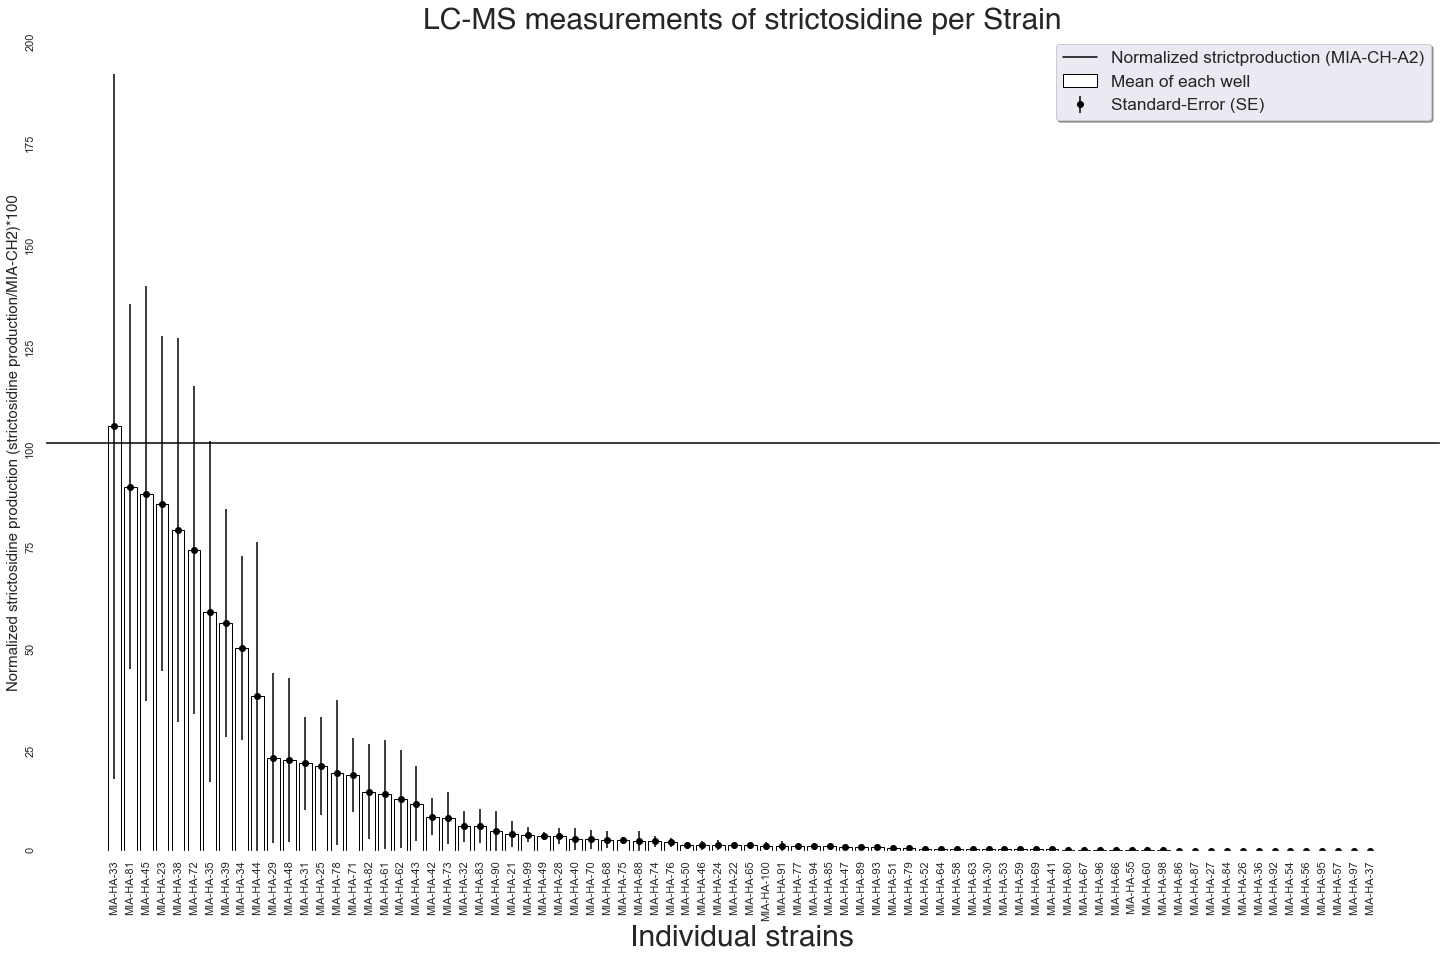

In [309]:
import matplotlib as mpl
from matplotlib.pyplot import figure

# Change size 
sns.set(rc = {'figure.figsize':(15,8)})

#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Plot
plt.bar(FIRST_ANA_strain_name, FIRST_ANA_strains_mean, edgecolor='black', color = 'white' ) # 
  
    
# Errorbar
plt.errorbar(FIRST_ANA_strain_name, FIRST_ANA_strains_mean, yerr=FIRST_ANA_strains_se, fmt="o", color="black",)# ms = 2)


# Change x labels rotation
ax.tick_params(rotation=90)

# Add labels and titel
ax.set_ylabel('Normalized strictosidine production (strictosidine production/MIA-CH2)*100', size = 15, fontname='Helvetica')
ax.set_xlabel('Individual strains', size = 30, fontname='Helvetica')
ax.set_title('LC-MS measurements of strictosidine per Strain', size = 30, fontname='Helvetica')
#plt.suptitle('Notes:\n - Triangels show individual measurements',x = 0.8,  y=0.6, fontsize=18, fontname='Helvetica')

# add horisontal line
plt.axhline(y = 100, color = 'black', linestyle = '-')

# Set color 
ax.set_facecolor("white")

# # Add legend
ax.legend(['Normalized strictproduction (MIA-CH-A2)', 'Mean of each well', 'Standard-Error (SE)', 'Individual datapoints'], loc='upper right', shadow=True, fontsize='x-large')


#### Addding all the datapoints as scatterplot
#x = indexes
#y = individual_strict_measurements_joined[:]
#length_of_dataset = individual_strict_measurements_joined[:]
#
#for i in range(len(individual_strict_measurements_joined)-1):
#    # add datapoint
#    if len(y[i]) > 1:
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#        ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#    else: 
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#
##ax.legend([ 'Individual datapoints'], loc='upper center', shadow=True, fontsize='x-large')
#
# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)
#
name = 'STRAINS FIRST ROUND LC-MS measurements of strictosidine DBTL1 w SE'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120,bbox_inches='tight')
#
#plt.show()

### 2nd round w SE

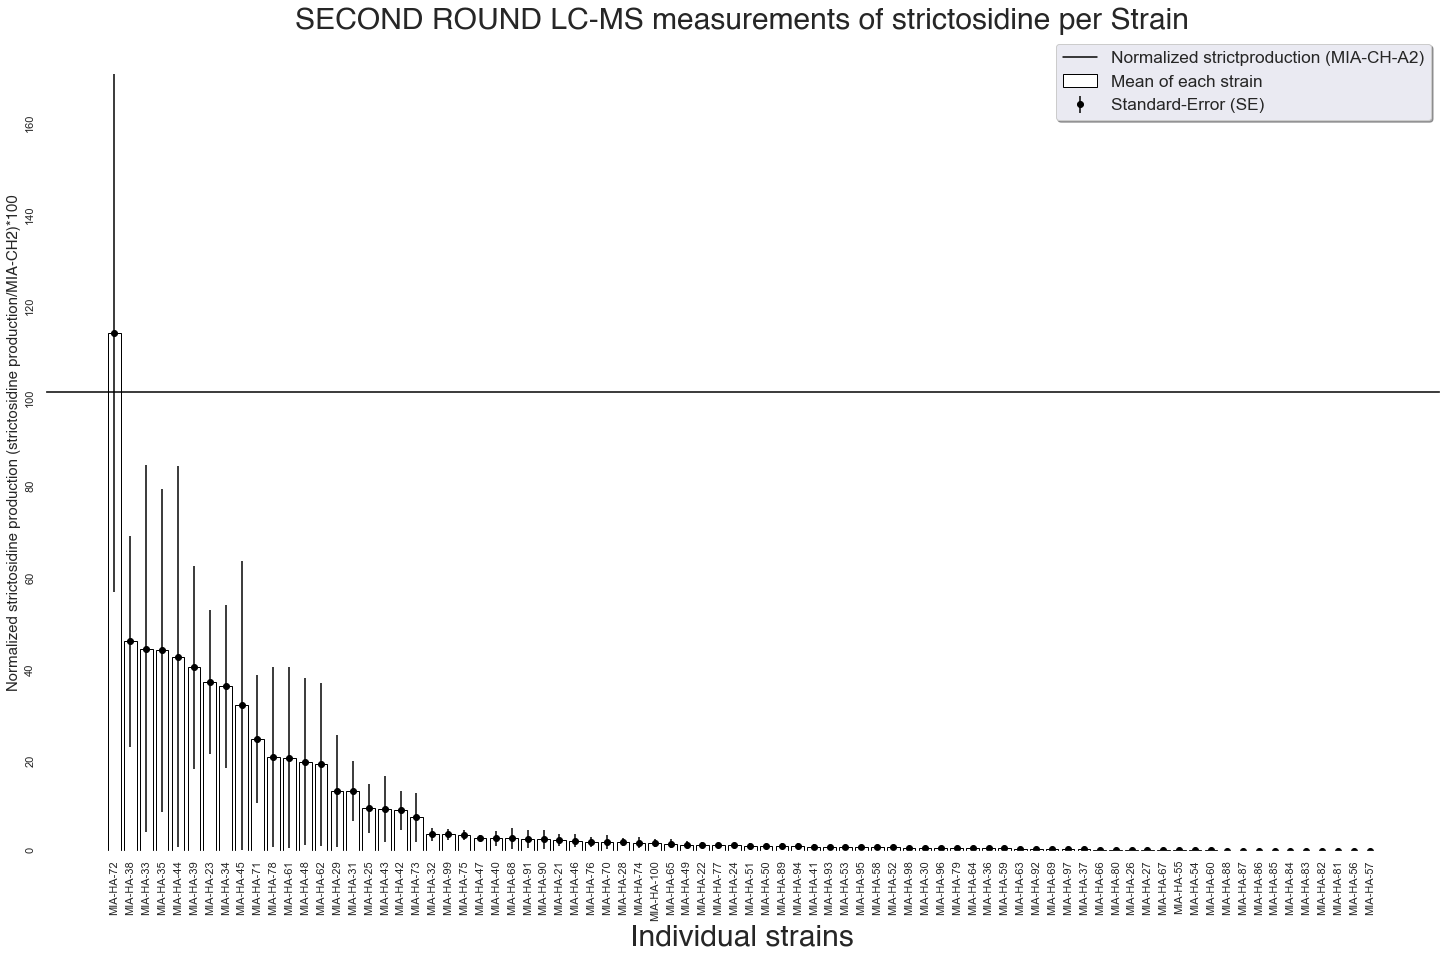

In [310]:
import matplotlib as mpl
from matplotlib.pyplot import figure

# Change size 
sns.set(rc = {'figure.figsize':(15,8)})

#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Plot
plt.bar(SECOND_ANA_strain_name, SECOND_ANA_strains_mean, edgecolor='black', color = 'white' ) # 
  
    
# Errorbar
plt.errorbar(SECOND_ANA_strain_name, SECOND_ANA_strains_mean, yerr=SECOND_ANA_strains_se, fmt="o", color="black",)# ms = 2)


# Change x labels rotation
ax.tick_params(rotation=90)

# Add labels and titel
ax.set_ylabel('Normalized strictosidine production (strictosidine production/MIA-CH2)*100', size = 15, fontname='Helvetica')
ax.set_xlabel('Individual strains', size = 30, fontname='Helvetica')
ax.set_title('SECOND ROUND LC-MS measurements of strictosidine per Strain', size = 30, fontname='Helvetica')
#plt.suptitle('Notes:\n - Triangels show individual measurements',x = 0.8,  y=0.6, fontsize=18, fontname='Helvetica')

# add horisontal line
plt.axhline(y = 100, color = 'black', linestyle = '-')

# Set color 
ax.set_facecolor("white")

# # Add legend
ax.legend(['Normalized strictproduction (MIA-CH-A2)', 'Mean of each strain', 'Standard-Error (SE)', 'Individual datapoints'], loc='upper right', shadow=True, fontsize='x-large')


#### Addding all the datapoints as scatterplot
#x = indexes
#y = individual_strict_measurements_joined[:]
#length_of_dataset = individual_strict_measurements_joined[:]
#
#for i in range(len(individual_strict_measurements_joined)-1):
#    # add datapoint
#    if len(y[i]) > 1:
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#        ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#    else: 
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#
##ax.legend([ 'Individual datapoints'], loc='upper center', shadow=True, fontsize='x-large')
#
# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)
#
name = 'STRAINS SECOND LC-MS measurements of strictosidine DBTL1 w SE'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120,bbox_inches='tight')
#
#plt.show()

In [214]:
new_df_per_well = df_first_and_second_round.groupby(['Line_name']).Normalized_strictosidine.agg({'mean','std'})
new_df_strain = df_first_and_second_round.groupby(['Strain']).Normalized_strictosidine.agg({'mean','std'})

#new_df['Strain'] = new_df.index
new_df_per_well.reset_index()
new_df_per_well = new_df_per_well.sort_values(by='mean', ascending = False)
new_df_per_well

,std,mean
Line_name,,
yp50_D03,108.336059,200.702654
yp49_F04,24.696704,156.403775
yp50_G03,58.114999,135.823691
yp50_D07,18.875454,126.883042
yp49_F05,58.217331,123.809937
...,...,...
yp50_E01,0.000000,0.000000
yp51_A12,0.000000,0.000000
yp51_A10,0.000000,0.000000


In [236]:
new_df_strain

,std,mean
Strain,,
MIA-HA-100,1.478895,1.469792
MIA-HA-21,3.968081,3.164230
MIA-HA-22,1.017747,1.296887
MIA-HA-23,55.007468,61.025896
MIA-HA-24,1.436004,1.215599
...,...,...
MIA-HA-95,0.577431,0.357355
MIA-HA-96,0.487246,0.382196
MIA-HA-97,0.267719,0.126299


### Calculating SE

In [242]:
import math 
# standard error 
std = list(new_df_per_well['std'])
std_strain = list(new_df_strain['std'])


def standard_error(std:list, length_of_datapoints:int):
    '''Calculates standard-error from a list of standard deviations
    and lenght of dataset.'''
    
    SE_list = []

    for stds in std: 
        SE_calc = stds/math.sqrt(length_of_datapoints)
        SE_list.append(SE_calc)
        
        
    return SE_list


SE_list = standard_error(std, 2)
SE_list_strain = standard_error(std, 6)
len(SE_list_strain)

238

In [246]:
new_df_strain

,std,mean
Strain,,
MIA-HA-100,1.478895,1.469792
MIA-HA-21,3.968081,3.164230
MIA-HA-22,1.017747,1.296887
MIA-HA-23,55.007468,61.025896
MIA-HA-24,1.436004,1.215599
...,...,...
MIA-HA-95,0.577431,0.357355
MIA-HA-96,0.487246,0.382196
MIA-HA-97,0.267719,0.126299


In [250]:
new_df_per_well['SE'] = SE_list
new_df_per_well

,Line_name,std,mean,SE
0,yp50_D03,108.336059,200.702654,76.605162
1,yp49_F04,24.696704,156.403775,17.463207
2,yp50_G03,58.114999,135.823691,41.093510
3,yp50_D07,18.875454,126.883042,13.346962
4,yp49_F05,58.217331,123.809937,41.165870
...,...,...,...,...
233,yp49_G10,0.000000,0.000000,0.000000
234,yp50_F02,0.000000,0.000000,0.000000
235,yp49_C06,0.000000,0.000000,0.000000
236,yp49_H12,0.000000,0.000000,0.000000


In [283]:
df_with_std_and_mean = df_first_and_second_round.merge(new_df_strain, left_on=['Strain'], right_index=True)
df_with_std_and_mean = df_with_std_and_mean.sort_values(by= 'mean', ascending = False)

# calculating SE
df_with_std_and_mean_SE_strains = standard_error(list(df_with_std_and_mean['std']),6)

# adding to dataframe
df_with_std_and_mean['SE'] = df_with_std_and_mean_SE_strains
df_with_std_and_mean

,Line_name,Normalized_strictosidine,Strain,Genotype,std,mean,SE
167,yp49_F06,0.215449,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
4,yp49_F05,82.644068,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
167,yp49_F06,0.104651,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
4,yp49_F05,164.975807,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
1,yp49_F04,173.866982,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
...,...,...,...,...,...,...,...
230,yp51_B08,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
211,yp51_B07,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
230,yp51_B08,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
211,yp51_B07,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000


In [284]:
strains_mean = list(df_with_std_and_mean['mean'])
strain_name = list(df_with_std_and_mean['Strain'])
strains_sd = list(df_with_std_and_mean['std'])
strains_se = list(df_with_std_and_mean['SE'])

strains_all_data_points = list(df_with_std_and_mean['Normalized_strictosidine'])


len(strains_mean)

470

## Plotting All strains -  Analytics 

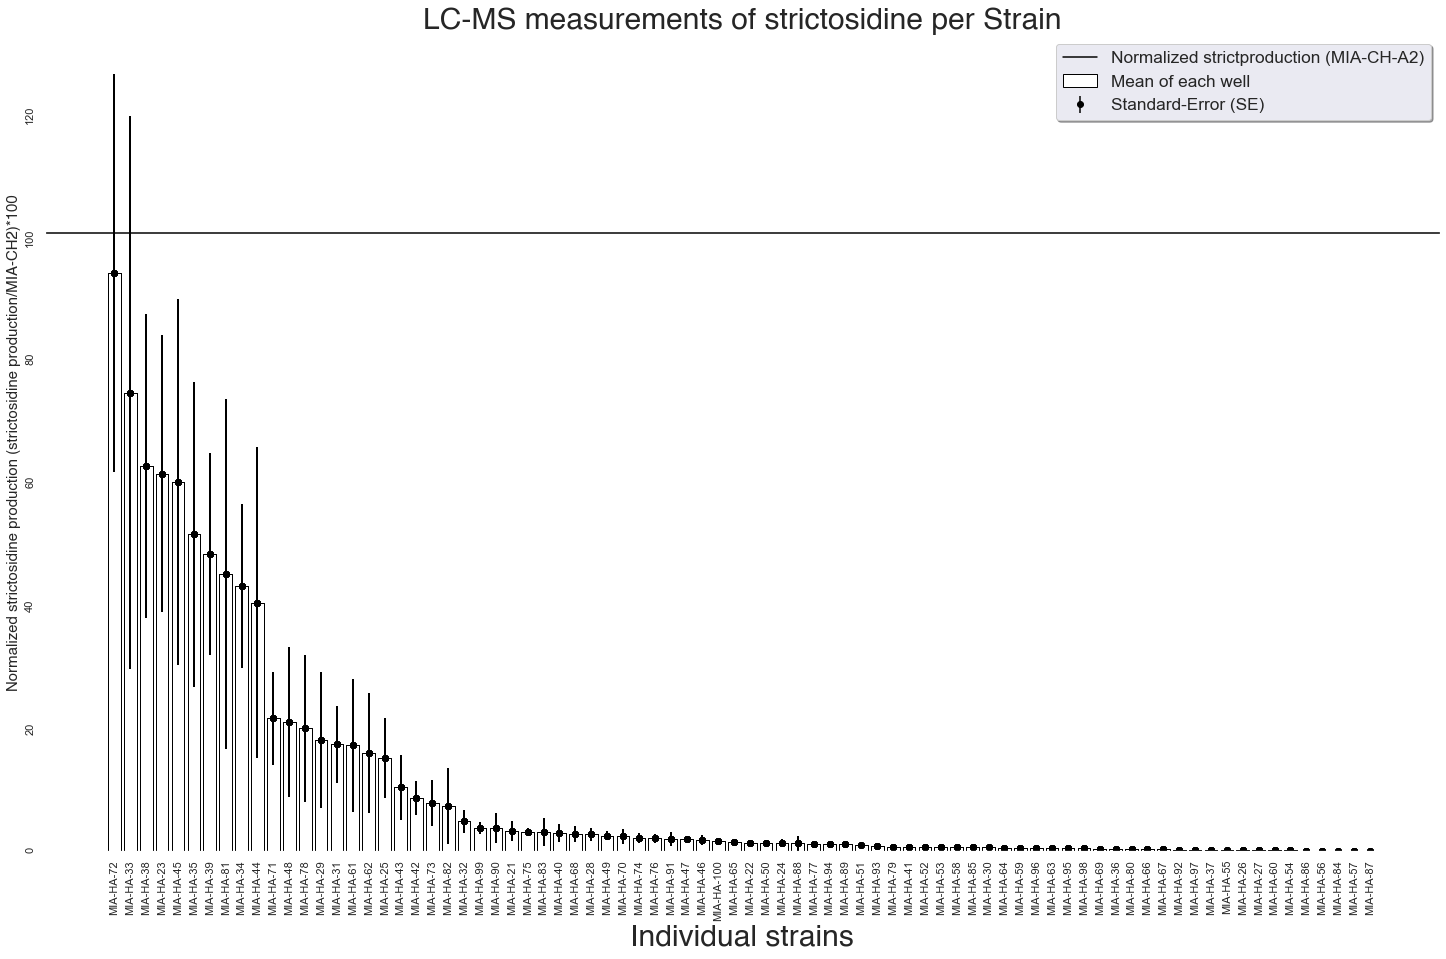

In [311]:
import matplotlib as mpl
from matplotlib.pyplot import figure

# Change size 
sns.set(rc = {'figure.figsize':(15,8)})


#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Plot
plt.bar(strain_name, strains_mean, edgecolor='black', color = 'white' ) # 
  
    
# Errorbar
plt.errorbar(strain_name, strains_mean, yerr=strains_se, fmt="o", color="black",)# ms = 2)


# Change x labels rotation
ax.tick_params(rotation=90)

# Add labels and titel
ax.set_ylabel('Normalized strictosidine production (strictosidine production/MIA-CH2)*100', size = 15, fontname='Helvetica')
ax.set_xlabel('Individual strains', size = 30, fontname='Helvetica')
ax.set_title('LC-MS measurements of strictosidine per Strain', size = 30, fontname='Helvetica')
#plt.suptitle('Notes:\n - Triangels show individual measurements',x = 0.8,  y=0.6, fontsize=18, fontname='Helvetica')

# add horisontal line
plt.axhline(y = 100, color = 'black', linestyle = '-')

# Set color 
ax.set_facecolor("white")

# # Add legend
ax.legend(['Normalized strictproduction (MIA-CH-A2)', 'Mean of each well', 'Standard-Error (SE)', 'Individual datapoints'], loc='upper right', shadow=True, fontsize='x-large')


#### Addding all the datapoints as scatterplot
#x = indexes
#y = individual_strict_measurements_joined[:]
#length_of_dataset = individual_strict_measurements_joined[:]
#
#for i in range(len(individual_strict_measurements_joined)-1):
#    # add datapoint
#    if len(y[i]) > 1:
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#        ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#    else: 
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#
##ax.legend([ 'Individual datapoints'], loc='upper center', shadow=True, fontsize='x-large')
#
# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)
#
name = 'STRAINS LC-MS measurements of strictosidine DBTL1 w SE'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120,bbox_inches='tight')
#
#plt.show()

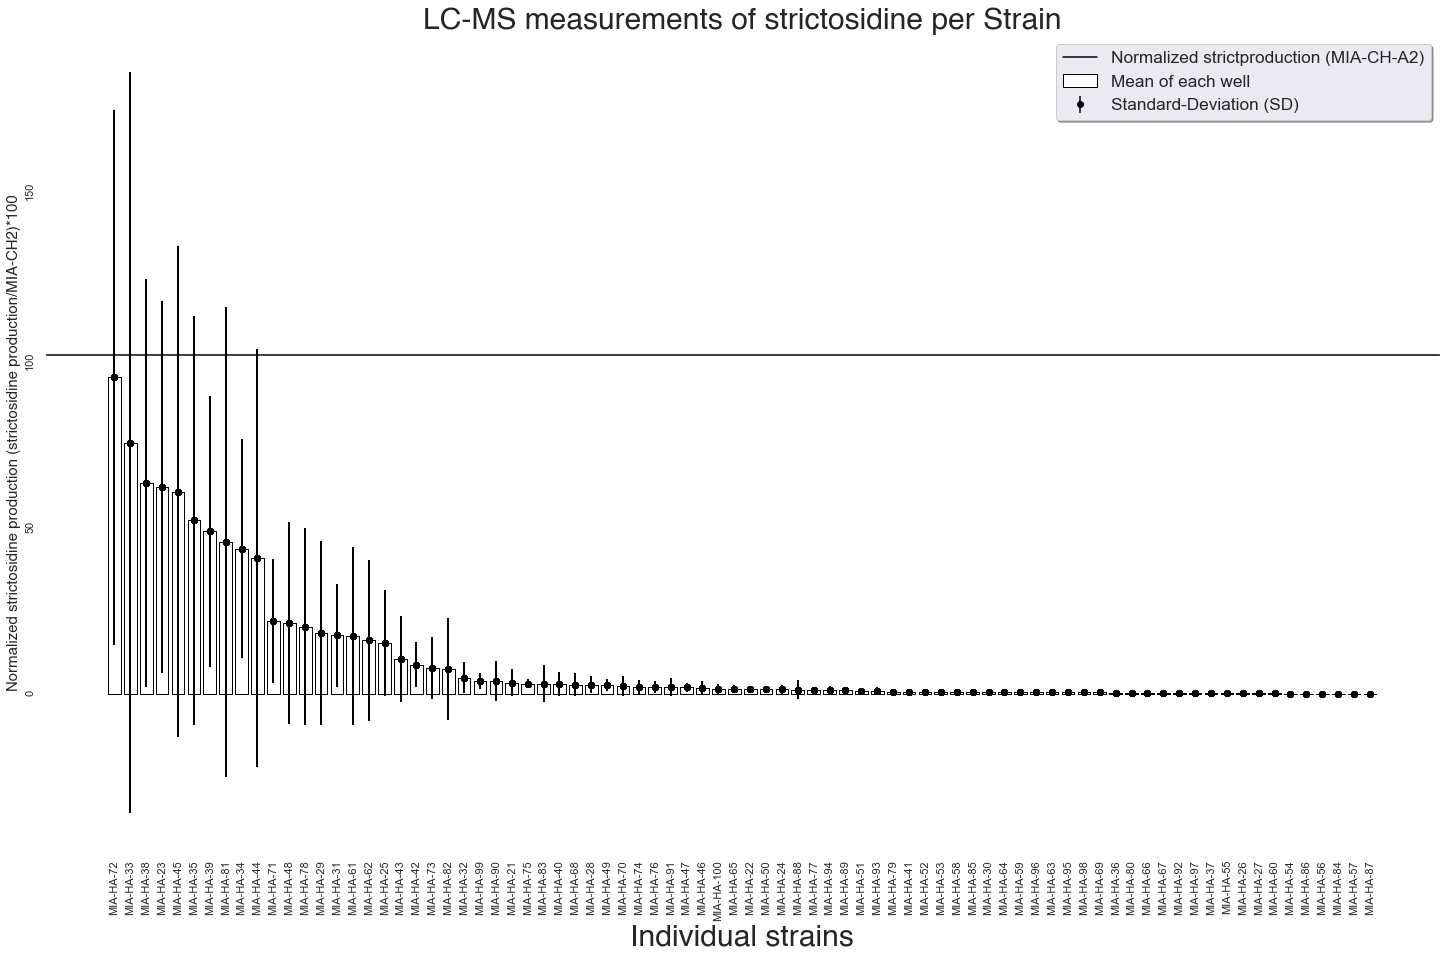

In [312]:
import matplotlib as mpl
from matplotlib.pyplot import figure

# Change size 
sns.set(rc = {'figure.figsize':(15,8)})


#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Plot
plt.bar(strain_name, strains_mean, edgecolor='black', color = 'white' ) # 
  
    
# Errorbar
plt.errorbar(strain_name, strains_mean, yerr=strains_sd, fmt="o", color="black",)# ms = 2)


# Change x labels rotation
ax.tick_params(rotation=90)

# Add labels and titel
ax.set_ylabel('Normalized strictosidine production (strictosidine production/MIA-CH2)*100', size = 15, fontname='Helvetica')
ax.set_xlabel('Individual strains', size = 30, fontname='Helvetica')
ax.set_title('LC-MS measurements of strictosidine per Strain', size = 30, fontname='Helvetica')
#plt.suptitle('Notes:\n - Triangels show individual measurements',x = 0.8,  y=0.6, fontsize=18, fontname='Helvetica')

# add horisontal line
plt.axhline(y = 100, color = 'black', linestyle = '-')

# Set color 
ax.set_facecolor("white")

# # Add legend
ax.legend(['Normalized strictproduction (MIA-CH-A2)', 'Mean of each well', 'Standard-Deviation (SD)', 'Individual datapoints'], loc='upper right', shadow=True, fontsize='x-large')


#### Addding all the datapoints as scatterplot
#x = indexes
#y = individual_strict_measurements_joined[:]
#length_of_dataset = individual_strict_measurements_joined[:]
#
#for i in range(len(individual_strict_measurements_joined)-1):
#    # add datapoint
#    if len(y[i]) > 1:
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#        ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#    else: 
#        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
#
##ax.legend([ 'Individual datapoints'], loc='upper center', shadow=True, fontsize='x-large')
#
# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)
#
name = 'STRAINS LC-MS measurements of strictosidine DBTL1 w SD'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120,bbox_inches='tight')
#
#plt.show()



In [313]:
df_with_std_and_mean

,Line_name,Normalized_strictosidine,Strain,Genotype,std,mean,SE
167,yp49_F06,0.215449,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
4,yp49_F05,82.644068,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
167,yp49_F06,0.104651,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
4,yp49_F05,164.975807,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
1,yp49_F04,173.866982,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
...,...,...,...,...,...,...,...
230,yp51_B08,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
211,yp51_B07,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
230,yp51_B08,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
211,yp51_B07,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000


In [314]:
df_with_std_and_mean

,Line_name,Normalized_strictosidine,Strain,Genotype,std,mean,SE
167,yp49_F06,0.215449,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
4,yp49_F05,82.644068,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
167,yp49_F06,0.104651,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
4,yp49_F05,164.975807,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
1,yp49_F04,173.866982,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
...,...,...,...,...,...,...,...
230,yp51_B08,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
211,yp51_B07,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
230,yp51_B08,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000
211,yp51_B07,0.000000,MIA-HA-87,OeuG8H AniCPR,0.000000,0.000000,0.000000


In [315]:
new_df_per_well = new_df_per_well.sort_values(by= 'mean', ascending= False)
new_df_per_well = new_df_per_well.reset_index()

new_df_per_well

,level_0,index,Line_name,std,mean,SE
0,0,0,yp50_D03,108.336059,200.702654,76.605162
1,1,1,yp49_F04,24.696704,156.403775,17.463207
2,2,2,yp50_G03,58.114999,135.823691,41.093510
3,3,3,yp50_D07,18.875454,126.883042,13.346962
4,4,4,yp49_F05,58.217331,123.809937,41.165870
...,...,...,...,...,...,...
233,214,232,yp50_B01,0.000000,0.000000,0.000000
234,215,233,yp49_G10,0.000000,0.000000,0.000000
235,216,234,yp50_F02,0.000000,0.000000,0.000000
236,217,235,yp49_C06,0.000000,0.000000,0.000000


In [316]:
new_df_mean_list = list(new_df_per_well['mean'])
strain = list(new_df_per_well.index)
new_df_SD_list = list((new_df_per_well['std']))

new_df_SE_list = list((new_df_per_well['SE']))
indexes = list(new_df_per_well.index)


### Plotting all datapoints with standard error - errorbars

In [317]:
merged_datapoints = pd.merge(new_df_per_well,df_with_std_and_mean , on="Line_name", how="outer", )
merged_datapoints = merged_datapoints.groupby("Line_name").apply(lambda x: x)
merged_datapoints

,level_0,index,Line_name,std_x,mean_x,SE_x,Normalized_strictosidine,Strain,Genotype,std_y,mean_y,SE_y
0,0,0,yp50_D03,108.336059,200.702654,76.605162,277.307816,MIA-HA-33,SmusG8H AraCPR,109.555298,74.111119,44.725763
1,0,0,yp50_D03,108.336059,200.702654,76.605162,124.097492,MIA-HA-33,SmusG8H AraCPR,109.555298,74.111119,44.725763
2,1,1,yp49_F04,24.696704,156.403775,17.463207,173.866982,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
3,1,1,yp49_F04,24.696704,156.403775,17.463207,138.940568,MIA-HA-72,CroG8H AanCPR,78.962051,93.457921,32.236122
4,2,2,yp50_G03,58.114999,135.823691,41.093510,176.917201,MIA-HA-45,RsepG8H RseCPR,72.557364,59.695047,29.621420
...,...,...,...,...,...,...,...,...,...,...,...,...
468,216,234,yp50_F02,0.000000,0.000000,0.000000,0.000000,MIA-HA-41,RsepG8H CroCPR,0.770247,0.573261,0.314452
469,216,234,yp50_F02,0.000000,0.000000,0.000000,0.000000,MIA-HA-41,RsepG8H CroCPR,0.770247,0.573261,0.314452
470,217,235,yp49_C06,0.000000,0.000000,0.000000,0.000000,MIA-HA-60,CacuG8H CpoCPR,0.065922,0.042469,0.026913
471,217,235,yp49_C06,0.000000,0.000000,0.000000,0.000000,MIA-HA-60,CacuG8H CpoCPR,0.065922,0.042469,0.026913


In [318]:
individual_strict_measurements = list(merged_datapoints['Normalized_strictosidine'])
Line_names = list(merged_datapoints['Line_name'])

In [319]:
len(individual_strict_measurements)

473

Joining the data in pairs for plotting on as scatter plot

In [320]:
individual_strict_measurements_joined = []
individula_names = []
stop = int(len(individual_strict_measurements)+-1)

for i in range(0, stop,  2): 
    
    first_names = (Line_names[i], Line_names[i+1])
    first_two = (individual_strict_measurements[i], individual_strict_measurements[i+1])

    #if 'yp52' not in first_names[0]:  
    if first_names[0] != first_names[1]: 

        individula_names.append([first_names[0]])
        individual_strict_measurements_joined.append([first_two[0]])

    else: 
        individula_names.append(first_names)
        individual_strict_measurements_joined.append(first_two)



len(individual_strict_measurements_joined)


236

In [321]:
len(individual_strict_measurements_joined)

236

/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_993/453054153.py:53: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_993/453054153.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_993/453054153.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size


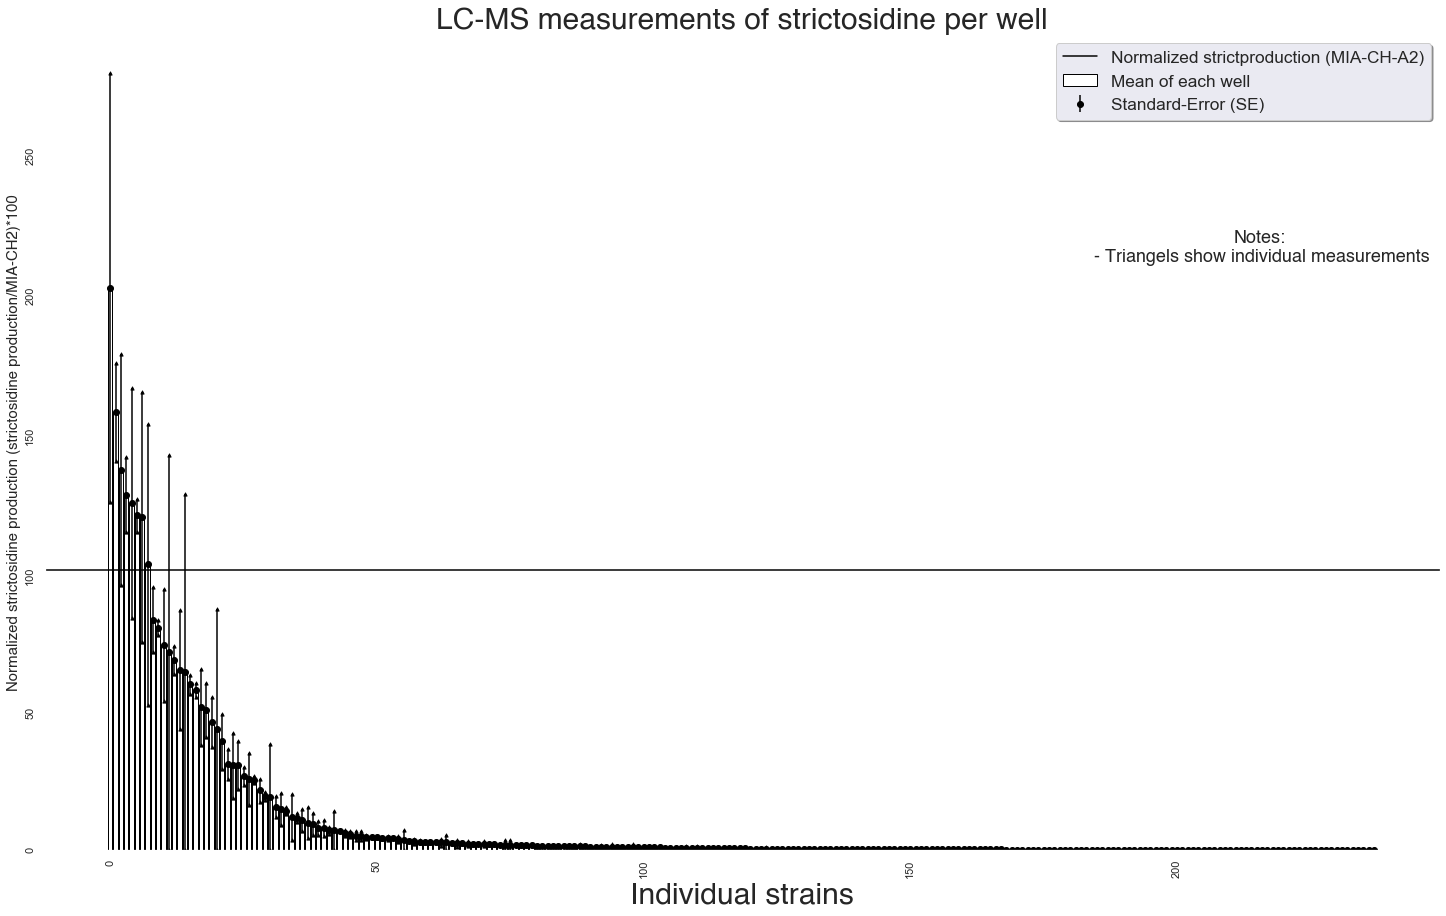

In [322]:
import matplotlib as mpl
from matplotlib.pyplot import figure

# Change size 
sns.set(rc = {'figure.figsize':(15,8)})


#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Plot
plt.bar(indexes, new_df_mean_list, edgecolor='black', color = 'white' ) # 
  
    
# Errorbar
plt.errorbar(indexes, new_df_mean_list, yerr=new_df_SE_list, fmt="o", color="black",)# ms = 2)


# Change x labels rotation
ax.tick_params(rotation=90)

# Add labels and titel
ax.set_ylabel('Normalized strictosidine production (strictosidine production/MIA-CH2)*100', size = 15, fontname='Helvetica')
ax.set_xlabel('Individual strains', size = 30, fontname='Helvetica')
ax.set_title('LC-MS measurements of strictosidine per well', size = 30, fontname='Helvetica')
plt.suptitle('Notes:\n - Triangels show individual measurements',x = 0.8,  y=0.7, fontsize=18, fontname='Helvetica')

# add horisontal line
plt.axhline(y = 100, color = 'black', linestyle = '-')

# Set color 
ax.set_facecolor("white")

# # Add legend
ax.legend(['Normalized strictproduction (MIA-CH-A2)', 'Mean of each well', 'Standard-Error (SE)', 'Individual datapoints'], loc='upper right', shadow=True, fontsize='x-large')


### Addding all the datapoints as scatterplot
x = indexes
y = individual_strict_measurements_joined[:]
length_of_dataset = individual_strict_measurements_joined[:]

for i in range(len(individual_strict_measurements_joined)-1):
    # add datapoint
    if len(y[i]) > 1:
        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
        ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
    else: 
        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 

#ax.legend([ 'Individual datapoints'], loc='upper center', shadow=True, fontsize='x-large')

# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)

name = 'LC-MS measurements of strictosidine DBTL1 w SE'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120,bbox_inches='tight')

plt.show()

### Plotting all datapoints with standard deviation - errorbars

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_993/339174530.py:41: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_993/339174530.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size
/var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/ipykernel_993/339174530.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size
1 extra bytes in post.stringData array
'created' timestamp seems v

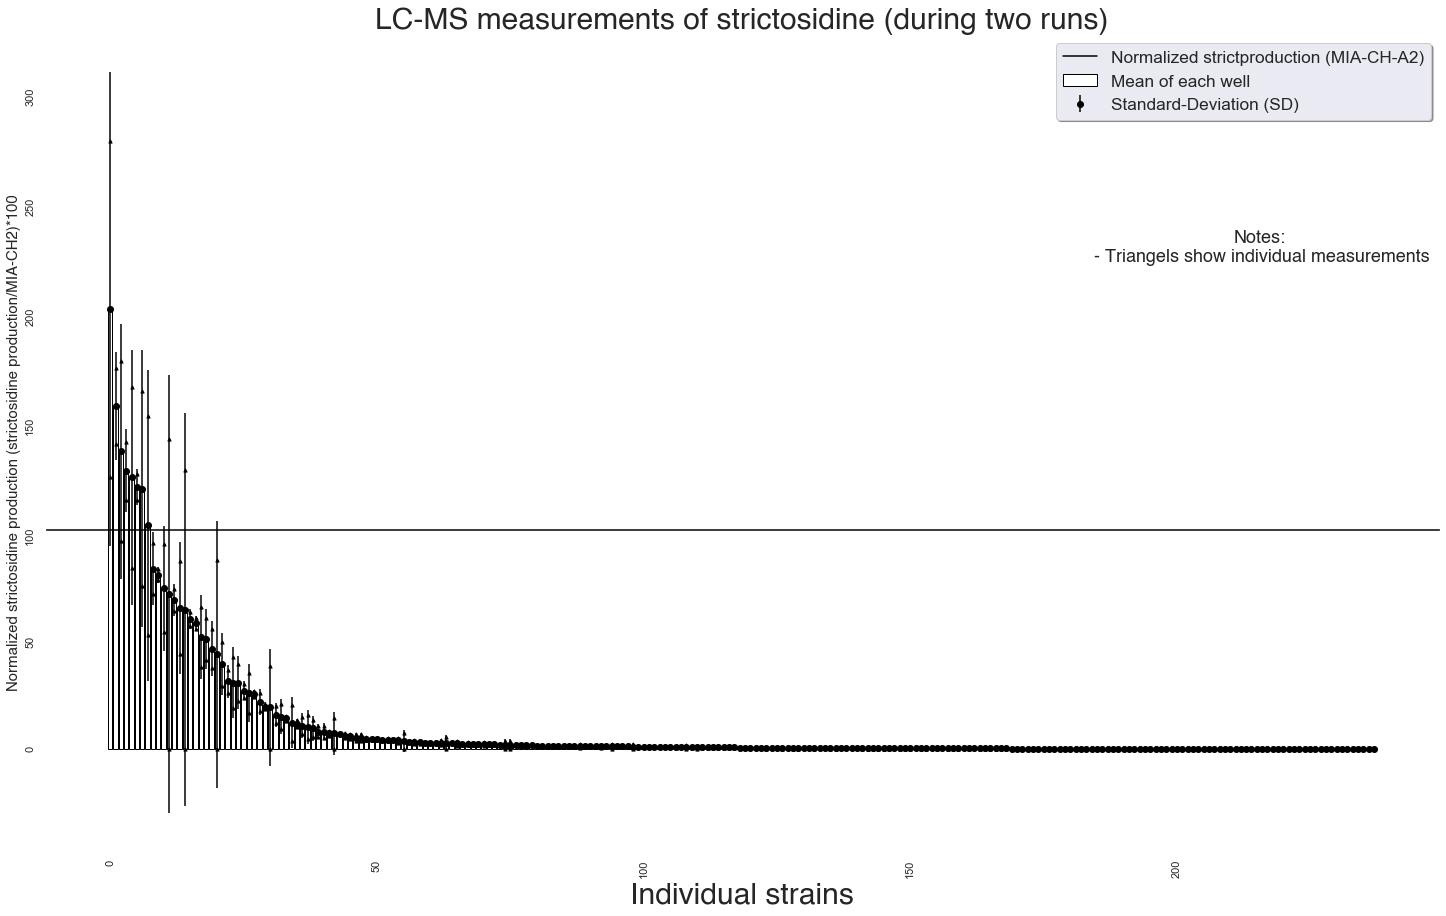

In [324]:
import matplotlib as mpl

#### How can I export a matplotlib figure as a vector graphic with editable text fields?
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt

# Create Figure and Axes instances
fig,ax = plt.subplots(1)

# Plot
plt.bar(indexes, new_df_mean_list, edgecolor='black' ,color = 'white' ) # 
  

# error bar  
plt.errorbar(indexes, new_df_mean_list, yerr=new_df_SD_list, fmt="o", color="black",)# ms = 2)
ax.tick_params(rotation=90)
ax.set_ylabel('Normalized strictosidine production (strictosidine production/MIA-CH2)*100', size = 15, fontname='Helvetica')
ax.set_xlabel('Individual strains', size = 30, fontname='Helvetica')
ax.set_title('LC-MS measurements of strictosidine (during two runs)', size = 30, fontname='Helvetica')
plt.axhline(y = 100, color = 'black', linestyle = '-')
ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Set color 
ax.set_facecolor("white")

# 
plt.suptitle('Notes:\n - Triangels show individual measurements',x = 0.8,  y=0.7, fontsize=18, fontname='Helvetica')
ax.legend(['Normalized strictproduction (MIA-CH-A2)', 'Mean of each well', 'Standard-Deviation (SD)', 'Individual datapoints'], loc='upper right', shadow=True, fontsize='x-large')

### Addding all the datapoints
x = indexes
y = individual_strict_measurements_joined[:]
length_of_dataset = individual_strict_measurements_joined[:]

for i in range(len(individual_strict_measurements_joined)-1):
    # add datapoint
    if len(y[i]) > 1:
        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
        ax.scatter(x[i]  , y[i][1], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
    else: 
        ax.scatter(x[i]  , y[i][0], color='black', norm= 0.1, s = 10, marker = "^") # s = size 
        
# SIze matters
fig = mpl.pyplot.gcf()
fig.set_size_inches(25, 15)

name = 'LC-MS measurements of strictosidine DBTL1 w SD'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.pdf',format = 'pdf',  dpi = 120,bbox_inches='tight')
# Show
plt.show()

## 2.2 Genotyping

Purpose: Determine promoters from library strains to enable ML based sampling of library space

Methods:
DNA sequencing of assembled clusters. 


Genomic DNA was extracted from
overnight cultures using the LiOAc/SDS method adapted to a 96-well microtiter
plate format. Each extract was used as a template in 2 PCR reactions spanning
the 2 integrated promoter gene pairs and amplifying from 2500 to 3200 bp. The PCR
products were validated using a LabChip GX II (Perkin Elmer) and sequenced
using PlateSeq PCR Kits (Eurofins) according to the manufacturer’s instructions.
From the LabChip results, a PCR reaction was considered as trusted if it showed a
strong band of the correct size; not trusted if it showed a strong band of the wrong
size, and as no information (NI) gained if it showed a weak or no band. 


From the
sequencing results, a sequencing reaction was considered as trusted if it showed an
unambiguous sequence of the expected length (i.e., only limited by length of PCR
fragment, stretches of the same nucleotide in the promoter or of ~1 kb limit of
sanger sequencing reactions), not trusted if it showed an unambiguous sequence of
the expected length with an assembly error, and NI gained if there were no or bad
sequence results. If one or more sequencing results from the same strain showed
double peaks in the promoter region the strain was considered as a double
population. Finally, the promoter was noted as a failed assembly if either LabChip
and or sequencing results were considered not trusted, as NI if the sequencing
result was NI and else as the promoter predicted by pairwise alignment between
sequencing results and promoter sequence.

## 2.3 Sequencing

### Submission


[Documents folder](ConStrain_on_google_colab/Data/raw/10_Sanger_results/Sanger/Submission/eurofins_upload_template_plateseq.xlsx)


Eurofins     | SDP_ID | cassette
------------ | ------ | --------
PCR_00020195 | yp49   | g8h
PCR_00020204 | yp50   | g8h
PCR_00020205 | yp51   | g8h
PCR_00020206 | yp49   | cpr
PCR_00020207 | yp50   | cpr
PCR_00020208 | yp51   | cpr

In plateseq kits well h12 is reserved for quality control.
In all 6 plates yp49-51 for g8h & cpr well h12 contains medium control which do not need to be sequenced. Thus no need to rearrange samples.

### Download and movement of files to correct folders 
[Eurofins Results](https://eurofinsgenomics.eu/pages)

In [ ]:
path = 'ConStrain_on_google_colab/Data/raw/10_Sanger_results/'
files = os.listdir(path)
files

In [ ]:
yp49_cpr = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp49_cpr.xls')
yp49_g8h = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp49_g8h.xls')
yp50_cpr = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp50_cpr.xls')
yp50_g8h = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp50_g8h.xls')
yp51_cpr = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp51_cpr.xls')
yp51_g8h = pd.read_excel('../data/raw/10_Sanger_results/PlateReport_yp51_g8h.xls')

# list of all the dataframes
sequencing_plates = [yp49_cpr, yp49_g8h, yp50_cpr, yp50_g8h, yp51_cpr, yp51_g8h]

In [ ]:
from constrain.test.genotyping import slicing_and_naming_seq_plates, plat_seq_data_wrangler, plate_AvgQual, split_df_names, concatenating_list_of_dfs

In [ ]:
len(sequencing_plates)

### Data wrangling of plateSeq2 excel files

In [ ]:
#Slicing plate data
sliced_plates = slicing_and_naming_seq_plates(sequencing_plates)

# Making the values numeric
list_of_dfs = plat_seq_data_wrangler(sliced_plates)

#filter them on their 
filtered_plates = plate_AvgQual(list_of_dfs)

# Split names
split_df = split_df_names(filtered_plates)

# concatenating the plates
all_data_frames = concatenating_list_of_dfs(split_df)

#merged_with_genotyping
all_data_frames

In [ ]:
## Adding a zero to all the numers before 10
wells = []
for index, row in all_data_frames.iterrows():
    if len(row['well']) == 2: 
        letter, number = row['well'][0:1], row['well'][1:2]
        #print(letter, number)
        row['well'] = letter + '0' + number
        wells.append(row['well'])
    else: 
        wells.append(row['well'])
        
        
all_data_frames['well'] = wells
all_data_frames

In [ ]:
concating_all_plates_with_bad_reads = concatenating_list_of_dfs(sequencing_plates)
concating_all_plates_with_bad_reads = concating_all_plates_with_bad_reads.replace('n.a.', np.NaN)
concating_all_plates_with_bad_reads = split_df_names([concating_all_plates_with_bad_reads])[0]
concating_all_plates_with_bad_reads

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(data=concating_all_plates_with_bad_reads, x="used", y="AvgQual", hue="AvgQual")
#g = sns.scatterplot(x="AvgQual", y="used", data=concating_all_plates_with_bad_reads)
None

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(data=all_data_frames, x="used", y="AvgQual", hue="AvgQual")
#g = sns.scatterplot(x="AvgQual", y="used", data=concating_all_plates_with_bad_reads)
None

### Manual ab1 and promoter check 

### Detailed check of assemblies
- Manuel filtering. trusted / not_trusted ab1. 
- For certains strains multiple ab1 sequences get ambiguous only in promoters -> double population
- ab1 sequences quality drops preliminary due to stretches of same nucleotides in certain promoters  -> trusted even though small seq alignment 
- Low quality ab1 -> not_trusted


In [ ]:
manual_checked = pd.read_excel('ConStrain_on_google_colab/Data/Sanger_seq_files/sequence_check2.xlsx')
manual_checked.head(10)

Lets parse through the file and add the sequences to the all_sequences dataframe 

In [ ]:
df_filterd_keep = manual_checked[manual_checked['Keep'] == True]

In [ ]:
# making Sample-name from the information above
#yp49_cpr_A1_pad_cpr_fw	

sample_names = []
for index, row in df_filterd_keep.iterrows():
    if row['position'] == 1:
        name = 'g8h'
    if row['position'] == 2:
        name = 'cpr'
    
    # Getting the right nomeclature
    if row['well'][1] == '0': 
        well = row['well'][0]+row['well'][2]  
    else: 
        well = row['well']

    sample_name = f"{row['plate']}_{name}_{well}_pad_{name}_fw"
    
    sample_names.append(sample_name)
    
df_filterd_keep['Sample-Name'] = sample_names


In [ ]:
df_filterd_keep

In [ ]:
# Sample-Name	inf_part_name	align_score	inf_part_number
df_filterd_keep = df_filterd_keep[['Sample-Name', 'inf_promoter']]
df_filterd_keep.columns = ['Sample-Name', 'inf_part_number']
df_filterd_keep.head()

## 2.4 Infering promoter to sample relationship

#### Primers used

In [ ]:
from Bio import SeqIO

In [ ]:
from constrain.lims.csv_database import get_dna_from_box_name
get_dna_from_box_name

In [ ]:
pad_pG8H_fw = get_dna_from_box_name('pad_pG8H_fw', 'primer_box', database_path = 'ConStrain_on_google_colab/Data/csv_database/')
pad_pCPR_fw = get_dna_from_box_name('pad_pCPR_fw', 'primer_box', database_path = 'ConStrain_on_google_colab/Data/csv_database/')


In [ ]:
primers_for_seq = [pad_pG8H_fw, pad_pCPR_fw]
primers_for_seq

#### Promoters to be aligned

In [ ]:
pG8H_template_names = ['pCYC1','pENO2','pPCK1','pRPL15B']
pCPR_template_names = ['pCCW12','pMLS1','pTPI1','pURE2']

In [ ]:
path = 'ConStrain_on_google_colab/Data/csv_database/'
genbank_path = 'ConStrain_on_google_colab/Data/genbank_files/'


pG8H_sites =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path,genbank = True, genbank_files_path = genbank_path) for name in pG8H_template_names]  
pCPR_sites =[get_dna_from_box_name(name, 'ds_dna_box', database_path = path, genbank = True, genbank_files_path = genbank_path) for name in pCPR_template_names]  


In [ ]:
templates = pCPR_sites+pG8H_sites

In [ ]:
templates

#### ab1 reads to be analysed

In [ ]:
path = 'ConStrain_on_google_colab/Data/raw/10_Sanger_results/ab1/'
files = os.listdir(path)
print(len(files))
reads = []
for read in files:
    if read.endswith('ab1'): 
        reads.append(SeqIO.read(path+read, 'abi'))


In [ ]:
reads[12]

## 2.5 Aligning promoters to reads - infer promoter alignment

In [ ]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]
numbers_list = [5, 7,6, 8, 1, 2, 3, 4]

for i in range(len(templates)): 
    templates[i].description = numbers_list[i]
    
templates

In [ ]:
# lets limit the alingment to only reads that are of proper quality
# all_data_frames
sample_names = df_filterd_keep['Sample-Name'].tolist()
print(len(sample_names))

good_samples = []
for i in range(len(reads)):
    for j in range(len(sample_names)): 
        if reads[i].name == sample_names[j]: 
            good_samples.append(reads[i])
            
            
len(good_samples)

In [ ]:
from constrain.test.genotyping import pairwise_alignment_of_templates

In [ ]:
len(templates)

## 2.6 Aligning the reads to the templates

In [ ]:
%%time

df_alignment = pairwise_alignment_of_templates(good_samples,templates, primers_for_seq)

df_alignment

In [ ]:
col_list =  list(df_alignment["align_score"])
print(col_list)

In [ ]:
minvalue = df_alignment['align_score'].min()
minvalue

In [ ]:
df_align_sort = df_alignment.sort_values(['Sample-Name'])
df_align_sort.tail(10)

In [ ]:
df_alignment['position'] = ''
position = []
for index, row in df_alignment.iterrows():
    split = str(row['Sample-Name'].split("_")[1])
    if split == 'g8h': 
        position.append(1)
    if split == 'cpr': 
        position.append(2)

df_alignment['position'] = position
df_alignment

grouping the positions

In [ ]:
grouped = df_alignment.groupby(df_alignment.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

g8h_df

In [ ]:
cpr_df

In [ ]:
# lets merge the quality dataframe
# all_data_frames
infered_promoters_df = pd.merge(concating_all_plates_with_bad_reads, df_alignment, left_on=['Sample-Name'], right_on = ['Sample-Name'])

In [ ]:
infered_promoters_df

#### Comparing to the manually currated dataframe

In [ ]:
indexes = []
new_inf_part = []
# manually curated
for index, row in df_filterd_keep.iterrows():
    
    # best pairwise alignment
    for index1, row1 in infered_promoters_df.iterrows():
        if row['Sample-Name'] == row1['Sample-Name']:
            if int(row['inf_part_number']) != int(row1['inf_part_number']):
                print('Not matching', row['inf_part_number'] , row1['inf_part_number'] , row['Sample-Name'] , row1['Sample-Name'])
                
                indexes.append(index1)
                new_inf_part.append(int(row['inf_part_number']))
                ## changing it to the manually curated one
                #infered_promoters_df.loc[index1].at['inf_part_number'] = 2
                #print('No match', row['inf_part_number'] , row1['inf_part_number'])


In [ ]:
# changing that 
infered_promoters_df1 = infered_promoters_df.copy(deep=True)
infered_promoters_df1['inf_part_number'][indexes[0]] = 2

In [ ]:
infered_promoters_df = infered_promoters_df1[["plate", "well", "inf_part_number", "position"]]
infered_promoters_df

In [ ]:
well_list = infered_promoters_df['well'].to_list()

new_well_list = []
for i in range(len(well_list)): 
    if len(well_list[i]) == 2:
        
        well = str(well_list[i][0:1])+'0'+str(well_list[i][1:2])
        new_well_list.append(well)
        well= ''
        
    else: 
        new_well_list.append(well_list[i])

infered_promoters_df['well'] = new_well_list
infered_promoters_df

In [ ]:
# grouping
grouped = infered_promoters_df.groupby(infered_promoters_df.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

#filtering
g8h_df = g8h_df[["plate", "well", "inf_part_number"]]
cpr_df = cpr_df[["plate", "well", "inf_part_number"]]

# changing names
g8h_df.columns = ['plate', 'well', 'inf_promoter1']
cpr_df.columns = ['plate', 'well', 'inf_promoter2']

promoter_to_well = pd.merge(g8h_df, cpr_df, left_on=['plate','well' ], right_on = ['plate','well'])
promoter_to_well

In [ ]:
print(len(g8h_df))
print(len(cpr_df))

Sanity check - did we get the correct promoters in each well? 


In [ ]:
for index, row in promoter_to_well.iterrows():
    if int(row['inf_promoter1']) > 4:
        print('SOMTHING WRONG WITH G8H', row['plate'], row['well'], index,row['inf_promoter1'])
    if int(row['inf_promoter2']) < 5:
            print('SOMTHING WRONG WITH CPR', row['plate'], row['well'], index)
print('SUCCESSSSS')


## 2.7 Re-sequencing 

As shown above alot we lose alot of samples because many of the CPR samples did not meet the quality criteria. Therefore we re-sequenced some of the samples again. 

In [ ]:
re_sequenced = pd.read_excel('ConStrain_on_google_colab/Data/Sanger_seq_files/ab1_first_round_resequencing/Mix2Seq - EF0000042174.xls')

# we can filter out the samples we need by only using samples with well not NAN
re_sequenced = re_sequenced[re_sequenced['Well'].notna()]
re_sequenced.head()

Importing the ab1 files

In [ ]:
path = 'ConStrain_on_google_colab/Data/Sanger_seq_files/ab1_first_round_resequencing/'
files = os.listdir(path)

reads_reseq = []
for read in files:
    if read.endswith('ab1'): 
        reads_reseq.append(SeqIO.read(path+read, 'abi'))
        
print(len(reads_reseq))

In [ ]:
reads_reseq[0]

In [ ]:
# cross-ref the tube-codes
tube_codes = list(re_sequenced['Tube Code'])

In [ ]:
# checking the reads match
i = 0
for name in reads_reseq: 
    if name.id not in tube_codes: 
        print(name.id)
    # the names for the reads are written like "id_id". we'll overwrite.
    name.name = name.id
i

In [ ]:
reads_reseq[0]

In [ ]:
%%time
df_alignment_reseq = pairwise_alignment_of_templates(reads_reseq,templates, primers_for_seq)

In [ ]:
df_alignment_reseq.head()

In [ ]:
promoter_to_well_reseq = pd.merge( df_alignment_reseq,re_sequenced, left_on=['Sample-Name' ], right_on = ['Tube Code'])
promoter_to_well_reseq.head()

Getting the positions ie. g8h or cpr

In [ ]:
positions =list(promoter_to_well_reseq['Primer'])
positions_for_df = []
for position in positions: 
    if position == 'pad_pCPR_fw': 
        positions_for_df.append(2)
    if position == 'pad_pG8H_fw': 
        positions_for_df.append(1)
promoter_to_well_reseq['position'] = positions_for_df

In [ ]:
promoter_to_well_reseq.head()

In [ ]:
promoter_to_well_reseq_filtered = promoter_to_well_reseq[['Sample', 'Well', 'inf_part_number', 'position']]
promoter_to_well_reseq_filtered.columns = ['plate', 'well', 'inf_part_number', 'position']
promoter_to_well_reseq_filtered.head()

In [ ]:
# concatenating with our previous dataframe 
infered_promoters_df = pd.concat([infered_promoters_df,promoter_to_well_reseq_filtered])

infered_promoters_df.tail()
print(len(infered_promoters_df))

In [ ]:
# grouping
grouped = infered_promoters_df.groupby(infered_promoters_df.position)
g8h_df = grouped.get_group(1)
cpr_df = grouped.get_group(2)

#filtering
g8h_df = g8h_df[["plate", "well", "inf_part_number"]]
cpr_df = cpr_df[["plate", "well", "inf_part_number"]]

# changing names
g8h_df.columns = ['plate', 'well', 'inf_promoter1']
cpr_df.columns = ['plate', 'well', 'inf_promoter2']

promoter_to_well = pd.merge(g8h_df, cpr_df, left_on=['plate','well' ], right_on = ['plate','well'])
print(len(promoter_to_well))
promoter_to_well.head()

In [ ]:
promoter_to_well = promoter_to_well.drop_duplicates(ignore_index = True)
len(promoter_to_well)

# 3. Combine data


In [ ]:
promoter_genotype_relationship = pd.merge(promoter_to_well, sorted_df_lcms, on=['plate','well' ])
len(promoter_genotype_relationship)

In [ ]:
promoter_genotype_relationship

In [ ]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


g8h_genotype = []
cpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in promoter_genotype_relationship.iterrows():
    g8h_geno = str(row['genotype'].split(" ")[0])
    cpr_geno = str(row['genotype'].split(" ")[1])
    
    
    g8h_pos = g8h_list_of_index.index(str(row['genotype'].split(" ")[0]))+1
    cpr_pos = cpr_list_of_index.index(str(row['genotype'].split(" ")[1]))+1

    
    g8h_genotype.append(g8h_pos)
    cpr_genotype.append(cpr_pos)
    
promoter_genotype_relationship['G8H'] = g8h_genotype
promoter_genotype_relationship['CPR'] = cpr_genotype

In [ ]:
promoter_genotype_relationship

In [ ]:
promoter_genotype_relationship = promoter_genotype_relationship[['Line_name', 'G8H','inf_promoter1', 'inf_promoter2', 'CPR',  'norm_strict_x','norm_strict_y',  'norm_strict_mean']]
promoter_genotype_relationship.columns = ['Line_name',  '0','1', '2', '3',  'norm_strict_x', 'norm_strict_y', 'norm_strict_mean']
promoter_genotype_relationship

In [ ]:
promoter_genotype_relationship

In [ ]:
#find duplicate rows across all columns
duplicateRows = promoter_genotype_relationship[promoter_genotype_relationship.duplicated(['Line_name'])]
duplicateRows

In [ ]:
promoter_genotype_relationship.drop_duplicates(subset = 'Line_name')

#### Export file

In [ ]:
promoter_genotype_relationship.to_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')


In [148]:
input_for_ml = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv', index_col=None)
input_for_ml

,Unnamed: 0,Line_name,0,1,2,3,norm_strict_x,norm_strict_y,norm_strict_mean
0,0,yp49_A01,1,2,5,1,0.972701,1.796170,1.384435
1,1,yp49_C01,1,2,5,9,0.536658,0.738584,0.637621
2,2,yp49_D01,2,4,7,3,0.175896,0.109680,0.142788
3,3,yp49_E01,2,1,5,7,0.345201,0.228028,0.286614
4,4,yp49_F01,3,3,6,1,26.416324,23.762944,25.089634
...,...,...,...,...,...,...,...,...,...
164,164,yp51_C12,8,3,7,2,0.000000,0.089923,0.044961
165,165,yp51_D12,8,2,7,6,0.614962,1.264863,0.939912
166,166,yp51_E12,8,1,6,10,0.466688,2.068186,1.267437
167,167,yp50_F05,6,1,8,2,15.155009,12.813656,13.984332


# 4. Plotting the results:

In [149]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}
promoter_dict

{1: 'pCYC1',
 2: 'pENO2',
 3: 'pPCK1',
 4: 'pRPL15B',
 5: 'pCCW12',
 6: 'pTPI1',
 7: 'pMLS1',
 8: 'pURE2'}

In [150]:
g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in input_for_ml.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

input_for_ml['G8H'] = g8h_genotype
input_for_ml['CPR'] = cpr_genotype
input_for_ml['pG8H'] = pg8h_genotype
input_for_ml['pCPR'] = pcpr_genotype

In [ ]:
for_plotting_input_for_ml = input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']]
for_plotting_input_for_ml

In [ ]:
simple_plotting = for_plotting_input_for_ml[['G8H', 'pG8H','pCPR', 'CPR']]
simple_plotting

In [ ]:
g8h_counts = pd.DataFrame(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = pd.DataFrame(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = pd.DataFrame(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = pd.DataFrame(for_plotting_input_for_ml["CPR"].value_counts())

all_counts = pd.concat([g8h_counts,pg8h_counts,pcpr_counts, cpr_counts ])
all_counts

In [ ]:
cpr_counts

In [ ]:
g8h_counts = dict(for_plotting_input_for_ml["G8H"].value_counts())
pg8h_counts = dict(for_plotting_input_for_ml["pG8H"].value_counts())
pcpr_counts = dict(for_plotting_input_for_ml["pCPR"].value_counts())
cpr_counts = dict(for_plotting_input_for_ml["CPR"].value_counts())

all_counts_as_list = [g8h_counts,pg8h_counts,pcpr_counts,cpr_counts]
all_counts_as_list

In [ ]:
def counting_occurences(data_with_occurences:dict): 
    columns = []
    data = []
    for key,value in data_with_occurences.items(): 

        values = cpr_counts.values()
        total = sum(values)

        data.append((value/total)*100)
        columns.append(key)
        
    return data, columns

In [ ]:
# Occurences
names_list = ['G8H', 'pG8H', 'pCPR', 'CPR']

dataframes = []
for i in range(len(all_counts_as_list)): 
    data, columns = counting_occurences(all_counts_as_list[i])

    dataframes.append(pd.DataFrame(data, columns=[names_list[i]], index=columns))

    print(data, columns)

In [ ]:
all_df_for_stacked_plot = pd.concat(dataframes)
all_df_for_stacked_plot = all_df_for_stacked_plot.T
all_df_for_stacked_plot

#### PRØVE 

In [ ]:
df = pd.read_csv('ConStrain_on_google_colab/Data/processed/ML_First_lib_predicted/Predicted_strict_named_CMP_MAE.csv')
simple_plotting = df[['G8H', 'pG8H','pCPR', 'CPR']]
simple_plotting
#g8h_counts = pd.DataFrame(for_plotting_input_for_ml["G8H"].value_counts())
#pg8h_counts = pd.DataFrame(for_plotting_input_for_ml["pG8H"].value_counts())
#pcpr_counts = pd.DataFrame(for_plotting_input_for_ml["pCPR"].value_counts())
#cpr_counts = pd.DataFrame(for_plotting_input_for_ml["CPR"].value_counts())
#
#all_counts = pd.concat([g8h_counts,pg8h_counts,pcpr_counts, cpr_counts ])
#all_counts


In [ ]:
G8H_list = list(simple_plotting['G8H'])
pG8H_list = list(simple_plotting['pG8H'])
pCPR_list = list(simple_plotting['pCPR'])
CPR_list = list(simple_plotting['CPR'])

In [ ]:
import seaborn as sns

g8h_color = ['#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
pg8H_color = ['#bae4b3','#74c476','#31a354','#006d2c']
pcpr_color = ['#fdbe85','#fd8d3c','#e6550d','#a63603']
#cpr_color = ['#800000','#990000','#b30000','#cc0000','#ff1a1a','#ff3333','#ff4d4d','#ff6666','#ff8080', '#ff9999']
#cpr_color= ['#ff9999','#ff8080','#ff6666','#ff4d4d','#ff3333','#ff1a1a','#cc0000','#b30000','#990000', '#800000']
cpr_color = ['#fcfbfd', '#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#3f007d', '#2d007d']

all_colors = g8h_color+ pg8H_color+ pcpr_color  +cpr_color

sns.set_theme( style='white')


ax = all_df_for_stacked_plot.plot( kind="bar",stacked = True,  figsize=(15, 10), color=all_colors) # , cmap="coolwarm"
# Add Title and Labels
plt.title('Occurences of each part sampled')
plt.xlabel('Parts')
plt.ylabel('Percentage of occurence')


# removes the borders around the plot
sns.despine(bottom = True, left = True)
ax.legend(frameon=False) # around the legend


# adding laves to each box
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    labels = [round(v.get_height()*100,2)  if v.get_height() > 0 else '' for v in c]
    
    # this one writes percent and 
    #labels = [[c.get_label(),round(v.get_height()*100,2)]  for v in c]

    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')


In [ ]:
import seaborn as sns

#g8h_color = ['#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
#pg8H_color = ['#bae4b3','#74c476','#31a354','#006d2c']
#pcpr_color = ['#fdbe85','#fd8d3c','#e6550d','#a63603']
##cpr_color = ['#800000','#990000','#b30000','#cc0000','#ff1a1a','#ff3333','#ff4d4d','#ff6666','#ff8080', '#ff9999']
##cpr_color= ['#ff9999','#ff8080','#ff6666','#ff4d4d','#ff3333','#ff1a1a','#cc0000','#b30000','#990000', '#800000']
#cpr_color = ['#fcfbfd', '#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#3f007d', '#2d007d']
#


ax = all_df_for_stacked_plot.plot( kind="bar",stacked = True,  figsize=(20, 15), color=all_colors,  edgecolor='Black') # , cmap="coolwarm"
# Add Title and Labels
plt.title('Occurences of each part sampled', fontsize=50)
plt.xlabel('Parts', fontsize=25)
plt.ylabel('Percentage of occurence - (part sampled/total parts in category)', fontsize=25)

# removes the borders around the plot
sns.despine(bottom = True, left = True)
ax.legend([],[],frameon=False) # around the legend

labels = []
# adding laves to each box
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    #labels = [round(v.get_height()*100,2)  if v.get_height() > 0 else '' for v in c]
    
    # this one writes label and percent 
    #labels = [f"{c.get_label()} : {round(v.get_height()*100,2)}"  for v in c]
    labels = [f"{c.get_label()}"  for v in c]

    #labels.append(c.get_label())

    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center', fmt='str', size = 25)

name = 'Occurences of each part sampled'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)


In [ ]:
import seaborn as sns

g8h_color = ['#deebf7','#deebf7','#c6dbef','#c6dbef','#9ecae1','#9ecae1','#6baed6','#6baed6']#,'#4292c6','#2171b5','#08519c','#08519c']
pg8H_color = ['#bae4b3','#74c476','#31a354','#006d2c']
pcpr_color = ['#fdbe85','#fd8d3c','#e6550d','#a63603']
cpr_color = ['#fcfbfd','#fcfbfd', '#efedf5', '#efedf5','#dadaeb','#dadaeb','#bcbddc','#bcbddc','#9e9ac8','#807dba','#6a51a3','#54278f','#54278f', '#54278f']
all_colors1 = g8h_color+ pg8H_color+ pcpr_color  +cpr_color


ax = all_df_for_stacked_plot.plot( kind="bar",stacked = True,  figsize=(20, 15), color=all_colors1,  edgecolor='Black') # , cmap="coolwarm"
# Add Title and Labels
plt.title('Occurences of each part DBTL1', fontsize=40)
plt.xlabel('Parts', fontsize=25)
plt.ylabel('Parts distribution (%)- (part sampled/total parts in category)', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)

# removes the borders around the plot
sns.despine(bottom = True, left = True)
ax.legend([],[],frameon=False) # around the legend

labels_for_test = []
# adding laves to each box
for c in ax.containers:

    # Optional: if the segment is small or 0, customize the labels
    #labels = [round(v.get_height()*100,2)  if v.get_height() > 0 else '' for v in c]
    
    # this one writes label and percent 
    labels_for_bars = [f"{c.get_label()} : {round(v.get_height(),2)} %"  for v in c]
    labels = [f"{c.get_label()}"  for v in c]

    labels_for_test.append(c.get_label())
    #for barcontainer in ax.containers:
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels_for_bars, label_type='center', fmt='str', size = 15)
    
name = 'Occurences of each part sampled'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)




#### First round

In [ ]:
first_round_top_producers = pd.read_csv('ConStrain_on_google_colab/Data/AutoML/input_for_ml_1st_iteration_all_analytics.csv')
first_round_top_producers = first_round_top_producers.sort_values(by='norm_strict_x', ascending=False)

In [ ]:
first_round_top_producers

In [ ]:
list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

promoter_dict = {i+1:list_of_promoters[i]for i in range(len(list_of_promoters))}


g8h_list_of_index = ["CacuG8H", "OpumG8H","CroG8H","VminG8H","SmusG8H","RsepG8H","OeuG8H","CcalG8H"]
cpr_list_of_index = ["CroCPR", "AanCPR","AraCPR","CloCPR","RseCPR","AhuCPR","AniCPR","CacCPR","OeuCPR","CpoCPR"]


list_of_promoters = ["pCYC1", "pENO2","pPCK1","pRPL15B", "pCCW12", "pTPI1","pMLS1","pURE2"]

pg8h_list_of_index = ['pCYC1', 'pENO2']
pcpr_list_of_index = ['pCCW12', 'pTPI1'] 



g8h_genotype = []
cpr_genotype = []
pg8h_genotype = []
pcpr_genotype = []

# adding index of genotypes to individual rows 
for index, row in first_round_top_producers.iterrows():
    # homologs
    g8h_name = g8h_list_of_index[int(row['0']-1)]
    cpr_name = cpr_list_of_index[int(row['3']-1)]
    
    # promoters
    pg8h_name =promoter_dict[row['1']]
    pcpr_name = promoter_dict[row['2']]
    
    
    # save the genotypes
    g8h_genotype.append(g8h_name)
    cpr_genotype.append(cpr_name)
    pg8h_genotype.append(pg8h_name)
    pcpr_genotype.append(pcpr_name)

first_round_top_producers['G8H'] = g8h_genotype
first_round_top_producers['CPR'] = cpr_genotype
first_round_top_producers['pG8H'] = pg8h_genotype
first_round_top_producers['pCPR'] = pcpr_genotype
first_round_top_producers

In [ ]:
top_producers_1st = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR','norm_strict_x' ]]
top_producers_2nd = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR','norm_strict_y' ]]
top_producers_merged = first_round_top_producers[['G8H', 'pG8H','pCPR', 'CPR','norm_strict_mean' ]]

top_producers_1st

In [ ]:
# Using DataFrame.agg() to combine two columns of text
top_producers_1st["Names"] = top_producers_1st[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
top_producers_1st = top_producers_1st.sort_values(by= 'norm_strict_x' , ascending = False)
top_producers_1st= top_producers_1st.reset_index()

first_round_top_producers_TOP20 = top_producers_1st[:20]
first_round_top_producers_TOP20

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# Font size
#sns.set_context("paper", rc={"font.size":8})

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))



# Initializing plot
sns.set_color_codes('pastel')
ax = sns.barplot(x = 'norm_strict_x', y = [i for i in first_round_top_producers_TOP20.index], data = first_round_top_producers_TOP20,
            label = '', color = 'b', edgecolor = 'w', orient = 'h', palette = 'Blues')

# adding a horisontal line
plt.axvline(100, color='black')

# adding laves to each box
first_round_top_producers_TOP20_NAMES = list(first_round_top_producers_TOP20['Names'])

# adding the labels on the bar
for c in ax.containers:
    ax.bar_label(c, labels=first_round_top_producers_TOP20_NAMES, label_type='center')
    ax.bar_label(c)

    
ax.set_title(f"1st round top producers")
    
    
#Save the plot 
name = 'Top20_strains_sampled_1st_analytics'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)


None

#### 2nd analytics

In [ ]:
# Using DataFrame.agg() to combine two columns of text
top_producers_2nd["Names"] = top_producers_2nd[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
top_producers_2nd = top_producers_2nd.sort_values(by= 'norm_strict_y' , ascending = False)
top_producers_2nd= top_producers_2nd.reset_index()

first_round_top_producers_TOP20 = top_producers_2nd[:20]
first_round_top_producers_TOP20

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# Font size
#sns.set_context("paper", rc={"font.size":8})

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))



# Initializing plot
sns.set_color_codes('pastel')
ax = sns.barplot(x = 'norm_strict_y', y = [i for i in first_round_top_producers_TOP20.index], data = first_round_top_producers_TOP20,
            label = '', color = 'b', edgecolor = 'w', orient = 'h', palette = ['#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b','#74c476','#41ab5d'])

# adding a horisontal line
plt.axvline(100, color='black')

# adding laves to each box
first_round_top_producers_TOP20_NAMES = list(first_round_top_producers_TOP20['Names'])

# adding the labels on the bar
for c in ax.containers:
    ax.bar_label(c, labels=first_round_top_producers_TOP20_NAMES, label_type='center')
    ax.bar_label(c)
    
ax.set_title(f"2st round top producers")
    
    
# Save the plot    
name = 'Top20_strains_sampled_2nd_analytics'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)



None

#### Merged analytics

In [ ]:
# Using DataFrame.agg() to combine two columns of text
top_producers_merged["Names"] = top_producers_merged[['G8H', 'pG8H','pCPR', 'CPR']].agg('-'.join, axis=1)
top_producers_merged = top_producers_merged.sort_values(by= 'norm_strict_mean' , ascending = False)
top_producers_merged= top_producers_merged.reset_index()

first_round_top_producers_TOP20 = top_producers_merged[:20]
first_round_top_producers_TOP20

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
# Font size
#sns.set_context("paper", rc={"font.size":8})

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 15))

['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#fd8d3c']

# Initializing plot
sns.set_color_codes('pastel')
ax = sns.barplot(x = 'norm_strict_mean', y = [i for i in first_round_top_producers_TOP20.index], data = first_round_top_producers_TOP20,
            label = '', color = 'b', edgecolor = 'w', orient = 'h', palette = ['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#fd8d3c'])

# adding a horisontal line
plt.axvline(100, color='black')

# adding laves to each box
first_round_top_producers_TOP20_NAMES = list(first_round_top_producers_TOP20['Names'])

# adding the labels on the bar
for c in ax.containers:
    ax.bar_label(c, labels=first_round_top_producers_TOP20_NAMES, label_type='center')
    ax.bar_label(c)
    
    
ax.set_title(f"Merged top producers", )
       
# Save the plot    
name = 'Top20_strains_sampled_merged_analytics'
plt.savefig('ConStrain_on_google_colab/Data/Plots_for_publication/DBTL1/'+name+'.svg',format = 'SVG',  dpi = 120)



None